# **El Impacto De Las Condiciones Ambientales En La Calidad Del Agua Del R√≠o De La Plata**



###  Mentor√≠a 7 | Trabajo Pr√°ctico Complementario ‚Äì Grupo 2
- Benitez, Macarena
- Castro Luna, Eduardo
- Gutierrez, Federico
- Wolowski, Mauro

Bibliografia :
-  Intendencia de Montevideo. (2022). Estudio de la calidad de agua del R√≠o de la Plata: Sistema Oeste, agosto‚Äìdiciembre 2021. Montevideo: Servicio de Evaluaci√≥n de la Calidad y Control Ambiental. Recuperado de https://montevideo.gub.uy/sites/default/files/biblioteca/informeestudiodelacalidadaguadelriodelaplatasistemaoesteagosto-diciembre2021.pdf

- Intendencia de Montevideo. (2015). Estudio de l√≠nea de base del R√≠o de la Plata [Informe t√©cnico]. Montevideo: Intendencia de Montevideo, Departamento de Calidad Ambiental. Recuperado de
 https://www.montevideo.gub.uy/sites/default/files/biblioteca/informeestudiodelineadebaseriodelaplata2015final.pdf

###Libreria

In [1]:
#Librerias

import pandas as pd
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import ee
import geemap
import datetime
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from datetime import datetime
from folium import Map, Marker, LayerControl, TileLayer, features
from branca.element import MacroElement
from jinja2 import Template
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from datetime import timedelta
from tqdm.notebook import tqdm


#### Dataset

In [69]:
# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)


# Variable objetivo

Se defini√≥ la variable clorofila_a_ug_l como objetivo del modelo, por ser un indicador ambiental clave vinculado a la calidad del agua. Esta variable es continua.  

**La medici√≥n de la clorofila en el agua es importante para evaluar la calidad del agua y la salud del ecosistema, ya que niveles altos de clorofila pueden indicar eutrofizaci√≥n y desequilibrios ecol√≥gicos.**

Otras variables complementarias fue campa√±a, fecha, turbidez del agua, temperatura

## *Resumen de descripci√≥n de la variable clorofila_a_ug_l*

In [ ]:
# Filtrar solo registros con clorofila v√°lida, pero conservar todas las columnas
df_validos = df[df['clorofila_a_ug_l'].notna()].copy()

In [ ]:
df_validos['clorofila'] = pd.to_numeric(df_validos['clorofila_a_ug_l'], errors='coerce')

In [5]:
# === 1) Trabajar sobre el texto original (antes de convertir a n√∫mero) ===
s_raw = df['clorofila_a_ug_l'].astype('string')  # preserva NA de pandas

def _normalize(x: pd.Series) -> pd.Series:
    y = x.fillna('')
    # quitar tildes
    y = y.apply(lambda t: unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('ascii'))
    # min√∫scula, trim y colapsar espacios
    y = y.str.lower().str.strip().str.replace(r'\s+', ' ', regex=True)
    return y

s_norm = _normalize(s_raw)

# === 2) M√°scaras por categor√≠a ===
# < n√∫mero (acepta coma o punto y espacios)
mask_lt = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
# > n√∫mero
mask_gt = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
# "no se midio / no se midi√≥" (ya normalizado sin tildes)
mask_no_midio = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
# Otros textos de faltante (si quer√©s ampliar, agreg√° m√°s t√©rminos dentro del grupo)
mask_sin_dato = s_norm.str_contains if hasattr(s_norm, 'str_contains') else s_norm.str.contains
mask_sin_dato = s_norm.str.contains(r'\b(?:sin dato|no medido|no medidos|no disponible|nd)\b', na=False)

# Subcategor√≠as observadas en tus datos (para no mezclar todo como "mal cargado")
mask_inaccesible = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*muestreo\b', na=False)
# mejor regex robusto para "no muestre√≥ / no se muestre√≥"
mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*(?:se\s*)?m(ue|ue)streo\b', na=False) | s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False)
# Simplificamos con una expresi√≥n m√°s general:
mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr(e|eo|e[o√≥])\w*\b', na=False)

mask_en_obra = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia = s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

# === 3) Conteos base ===
total_valores = len(s_raw)
valores_nulos = s_raw.isna().sum()
valores_con_lt = mask_lt.sum()
valores_con_gt = mask_gt.sum()
valores_no_se_midio = mask_no_midio.sum()
valores_otro_texto_faltante = mask_sin_dato.sum()

# Subcategor√≠as
c_inaccesible = mask_inaccesible.sum()
c_no_muestreo = mask_no_muestreo.sum()
c_en_obra = mask_en_obra.sum()
c_no_midieron_dia = mask_no_midieron_dia.sum()

# Identificar n√∫meros v√°lidos (para aislar textos que no son n√∫mero)
es_numero_valido = pd.to_numeric(s_norm.str.replace(',', '.', regex=False), errors='coerce').notna()

# Texto no vac√≠o:
mask_texto = ~es_numero_valido & s_norm.ne('')

# Conjunto de categor√≠as textuales ya identificadas
mask_categorizado = (
    mask_lt | mask_gt | mask_no_midio | mask_sin_dato |
    mask_inaccesible | mask_no_muestreo | mask_en_obra | mask_no_midieron_dia
)

# Resto de textos no categorizados (mal cargados)
valores_mal_cargados = (mask_texto & ~mask_categorizado).sum()

# === 4) Resumen ===
resumen = pd.DataFrame({
    'Descripci√≥n': [
        'Total de valores',
        'Valores nulos (NaN)',
        'Valores con "<x"',
        'Valores con ">x"',
        'Valores con "no se midio/midi√≥"',
        'Otros textos de faltante ("sin dato", "no medido", "nd")',
        '‚Äî Subcat: "inaccesible"',
        '‚Äî Subcat: "no muestre√≥ / no se muestre√≥"',
        '‚Äî Subcat: "en obra"',
        '‚Äî Subcat: "no midieron este d√≠a"',
        'Valores de texto no categorizado (mal cargados)'
    ],
    'Cantidad': [
        total_valores,
        valores_nulos,
        valores_con_lt,
        valores_con_gt,
        valores_no_se_midio,
        valores_otro_texto_faltante,
        c_inaccesible,
        c_no_muestreo,
        c_en_obra,
        c_no_midieron_dia,
        valores_mal_cargados
    ]
})

print("Resumen de descripci√≥n de la variable objeto:")
print(resumen)

# === 5) Ejemplos por categor√≠a ===
def _ejemplos(mask, titulo, n=10):
    ej = df.loc[mask, 'clorofila_a_ug_l'].head(n)
    print(f"\nEjemplos: {titulo} (hasta {n})")
    if len(ej) == 0:
        print("‚Äî (sin ejemplos)")
    else:
        print(ej.to_string(index=False))

_ejemplos(mask_lt, 'valores con "<x"')
_ejemplos(mask_gt, 'valores con ">x"')
_ejemplos(mask_no_midio, 'valores con "no se midio/midi√≥"')
_ejemplos(mask_sin_dato, 'otros textos de faltante ("sin dato", "no medido", "nd")')
_ejemplos(mask_inaccesible, 'subcat: "inaccesible"')
_ejemplos(mask_no_muestreo, 'subcat: "no muestre√≥ / no se muestre√≥"')
_ejemplos(mask_en_obra, 'subcat: "en obra"')
_ejemplos(mask_no_midieron_dia, 'subcat: "no midieron este d√≠a"')


Resumen de descripci√≥n de la variable objeto:
                                          Descripci√≥n  Cantidad
0                                    Total de valores       613
1                                 Valores nulos (NaN)        41
2                                    Valores con "<x"       238
3                                    Valores con ">x"         0
4                     Valores con "no se midio/midi√≥"        29
5   Otros textos de faltante ("sin dato", "no medi...         0
6                             ‚Äî Subcat: "inaccesible"         2
7            ‚Äî Subcat: "no muestre√≥ / no se muestre√≥"        11
8                                 ‚Äî Subcat: "en obra"         4
9                    ‚Äî Subcat: "no midieron este d√≠a"         4
10    Valores de texto no categorizado (mal cargados)         7

Ejemplos: valores con "<x" (hasta 10)
<0.001
<0.010
 <0.01
<0.001
 <0.01
<0.001
<0.010
<0.001
<0.010
<0.001

Ejemplos: valores con ">x" (hasta 10)
‚Äî (sin ejemplos)

Ejem

/tmp/ipython-input-1517173143.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False) | s_norm.str.contains(r'\bno\s*(?:se\s*)?m(ue|ue)streo\b', na=False) | s_norm.str.contains(r'\bno\s*(?:se\s*)?muestreo\b', na=False)
/tmp/ipython-input-1517173143.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_no_muestreo = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr(e|eo|e[o√≥])\w*\b', na=False)


En Argentina, no hay una normativa espec√≠fica nacional que indique c√≥mo tratar los valores censurados (‚Äú< LOD‚Äù) en clorofila, pero el procedimiento sigue est√°ndares internacionales adoptados a nivel local, y se cumple mediante acreditaci√≥n de laboratorios seg√∫n normas como ISO/IEC 17025.
Cuando una muetra tiene valores como <0.5 ¬µg/L, no es un cero, sino que est√° por debajo del l√≠mite que el m√©todo puede medir.
Los valores por debajo del l√≠mite de detecci√≥n (LD) no deben interpretarse como ceros, ya que representan concentraciones existentes pero no cuantificables con precisi√≥n. En estos casos, dichos valores se consideran censurados inferiores y pueden sustituirse por un valor constante, como por ejemplo, la mitad del LD (LD/2) o el LD dividido por la ra√≠z cuadrada de 2 (LD/‚àö2), seg√∫n recomendaciones de la EPA y buenas pr√°cticas estad√≠sticas. Esta imputaci√≥n conservadora permite incluir dichos datos en los an√°lisis sin introducir sesgos significativos.

*Minimo, Maximo*

In [6]:
# Convertir a num√©rico forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Mostrar m√≠nimo y m√°ximo
print(" Valores de clorofila v√°lidos (¬µg/L):")
print("M√≠nimo:", df['clorofila_a_ug_l'].min())
print("M√°ximo:", df['clorofila_a_ug_l'].max())



 Valores de clorofila v√°lidos (¬µg/L):
M√≠nimo: 0.0
M√°ximo: 6410.0


##Estaditica por campa√±a y a√±o

In [7]:
# Limpieza de campa√±a
df['campa√±a'] = df['campa√±a'].astype(str).str.strip().str.lower()

# Limpieza de a√±o
df['a√±o'] = pd.to_numeric(df['a√±o'], errors='coerce')  # convierte '2021.0' -> 2021.0 y descarta strings

# Convertir clorofila a num√©rico
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar solo datos v√°lidos
df_valido = df[
    df['clorofila_a_ug_l'].notna() &
    df['campa√±a'].isin(['invierno', 'primavera']) &
    df['a√±o'].isin([2021, 2022,2023])
]

# Agrupar por campa√±a y a√±o, calcular estad√≠sticas
estadisticas = df_valido.groupby(['campa√±a', 'a√±o'])['clorofila_a_ug_l'].agg(
    media='mean',
    m√≠nimo='min',
    m√°ximo='max',
    desv√≠o_est√°ndar='std'
).reset_index()

# Mostrar resultados
print(" Estad√≠sticas de clorofila por campa√±a y a√±o (¬µg/L):")
print(estadisticas)

 Estad√≠sticas de clorofila por campa√±a y a√±o (¬µg/L):
     campa√±a     a√±o        media   m√≠nimo      m√°ximo  desv√≠o_est√°ndar
0   invierno  2021.0     0.078800    0.011     0.22100         0.094298
1   invierno  2022.0  1578.260870  200.000  6410.00000      1564.921294
2   invierno  2023.0     9.511818    0.420    67.76000        14.659288
3  primavera  2021.0     0.062426    0.000     0.84016         0.153967
4  primavera  2022.0    14.329730    0.000    92.40000        22.950610
5  primavera  2023.0    31.190000   10.700    84.80000        23.338878


Los resultados muestran que en invierno y primavera de 2021, las concentraciones de clorofila-a fueron muy bajas, con medias por debajo de 0.08 ¬µg/L, valores m√°ximos moderados (‚â§ 0.84 ¬µg/L) y desv√≠os est√°ndar reducidos, lo que indica una distribuci√≥n homog√©nea y condiciones oligotr√≥ficas (baja productividad biol√≥gica) generalizadas durante ese a√±o.
Sin embargo, en invierno de 2022 se observa un salto abrupto en la media (1578 ¬µg/L) y en el valor m√°ximo (6410 ¬µg/L), junto con un desv√≠o est√°ndar extremadamente alto (1564 ¬µg/L). Esta combinaci√≥n sugiere la presencia de valores an√≥malamente elevados que podr√≠an corresponder a errores de medici√≥n, cargas puntuales intensas de nutrientes, floraciones algales extremas o errores en la estimaci√≥n satelital o interpolaci√≥n de datos.
En primavera de 2022, si bien los valores tambi√©n son significativamente m√°s altos que en 2021, la media se reduce a 14.3 ¬µg/L con un m√°ximo de 92.4 ¬µg/L. El desv√≠o est√°ndar sigue siendo considerable (22.95), lo que indica mayor heterogeneidad espacial, aunque m√°s moderada que en el invierno anterior.

### Nuevo dataset con eliminacion de Nan, valores mal cargado

In [8]:
# --- Definir columna a normalizar ---
COL = "clorofila_a_ug_l"
# --- Normalizaci√≥n para analizar texto ---
s_raw = df[COL].astype("string").fillna("")

def _normalize(x: pd.Series) -> pd.Series:
    y = x.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii","ignore").decode("ascii"))
    y = y.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return y

s_norm = _normalize(s_raw)

# --- Detectar casos especiales ---
mask_lt             = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_gt             = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_no_midio       = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
mask_inaccesible    = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo    = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr\w+\b', na=False)
mask_en_obra        = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia= s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

# Detectar n√∫meros v√°lidos
es_numero_valido = pd.to_numeric(s_norm.str.replace(",", ".", regex=False), errors="coerce").notna()
mask_texto       = ~es_numero_valido & s_norm.ne("")

# Texto que no cae en ninguna categor√≠a conocida ‚Üí mal cargados
mask_categorizado = (
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_lt | mask_gt
)
mask_mal_cargado = mask_texto & ~mask_categorizado

# --- Crear dataset nuevo ---
df_nuevo = df.copy()

# Reemplazar "<x" por el valor num√©rico limpio
df_nuevo.loc[mask_lt, COL] = (
    s_raw[mask_lt]
    .str.replace("<", "", regex=False)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

# Convertir toda la columna a num√©rico
df_nuevo[COL] = pd.to_numeric(df_nuevo[COL], errors="coerce")

# --- Filtrar excluyendo las categor√≠as indicadas ---
mask_to_drop = (
    df_nuevo[COL].isna() |
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_mal_cargado
)

df_nuevo = df_nuevo.loc[~mask_to_drop].copy()
df_nuevo.reset_index(drop=True, inplace=True)

# --- Reporte ---
conteos = {
    "Valores nulos (NaN)": int(df[COL].isna().sum()),
    '"no se midio/midi√≥"': int(mask_no_midio.sum()),
    "inaccesible": int(mask_inaccesible.sum()),
    "no muestre√≥ / no se muestre√≥": int(mask_no_muestreo.sum()),
    "en obra": int(mask_en_obra.sum()),
    "no midieron este dia": int(mask_no_midieron_dia.sum()),
    "texto no categorizado (mal cargados)": int(mask_mal_cargado.sum())
}

print("Conteos de lo eliminado:")
print(pd.Series(conteos).to_frame("Cantidad"))

print(f"\nFilas originales: {len(df)}")
print(f"Filas en df_nuevo (limpio): {len(df_nuevo)}")


Conteos de lo eliminado:
                                      Cantidad
Valores nulos (NaN)                        336
"no se midio/midi√≥"                          0
inaccesible                                  0
no muestre√≥ / no se muestre√≥                 0
en obra                                      0
no midieron este dia                         0
texto no categorizado (mal cargados)         0

Filas originales: 613
Filas en df_nuevo (limpio): 277


/tmp/ipython-input-3595715994.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<StringArray>
[]
Length: 0, dtype: string' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_nuevo.loc[mask_lt, COL] = (


## Clasificar los valores de clorofila seg√∫n rangos ambientales de referencia

### *Valores con clorofila 0*

In [9]:
# Identificacion de valores v√°lidos que no caen en ninguno de los tres rangos
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')
df_validos = df[df['clorofila_a_ug_l'].notna()]

df_faltantes = df_validos[
    ~(
        ((df_validos['clorofila_a_ug_l'] > 0) & (df_validos['clorofila_a_ug_l'] <= 5)) |
        ((df_validos['clorofila_a_ug_l'] >= 5) & (df_validos['clorofila_a_ug_l'] <= 100)) |
        ((df_validos['clorofila_a_ug_l'] > 100) & (df_validos['clorofila_a_ug_l'] <= 6500))
    )
]

print(f"N√∫mero de valores fuera de los rangos definidos: {len(df_faltantes)}")
display(df_faltantes[['clorofila_a_ug_l', 'latitud', 'longitud', 'a√±o', 'campa√±a']])

N√∫mero de valores fuera de los rangos definidos: 23


clorofila_a_ug_l      latitud     longitud     a√±o    campa√±a
0                 0.0          NaN          NaN  2021.0     verano
8                 0.0  -34.662.789  -58.296.669  2021.0     verano
12                0.0       -34.63  -58.328.339  2021.0     verano
16                0.0          NaN          NaN  2021.0     verano
58                0.0          NaN          NaN  2021.0     verano
66                0.0  -34.563.231  -58.404.119  2021.0     verano
70                0.0  -34.612.761  -58.340.611  2021.0     verano
104               0.0  -34.438.919  -58.536.519  2021.0     verano
116               0.0  -34.484.169   -5.847.945  2021.0     verano
124               0.0          NaN          NaN  2021.0     verano
132               0.0          NaN          NaN  2021.0     verano
135               0.0          NaN          NaN  2021.0  primavera
136               0.0  -34.408.061  -58.590.839  2021.0     verano
140               0.0          NaN          NaN  2021.0     verano
148               0.0          NaN          NaN  2021.0     verano
160               0.0          NaN          NaN  2021.0     verano
164               0.0  -34.505.531  -58.473.719  2021.0     verano
168               0.0          NaN          NaN  2021.0     verano
269               0.0   -3.469.195  -58.253.889  2022.0  primavera
313               0.0  -34.408.061  -58.590.839  2022.0  primavera
317               0.0          NaN          NaN  2022.0  primavera
321               0.0  -34.384.169  -58.632.511  2022.0  primavera
345               0.0          NaN          NaN  2022.0  primavera

Como paso adicional, se prob√≥ clasificar los valores de clorofila seg√∫n rangos ambientales de referencia: de 0 a 5‚ÄØ¬µg/L, de 5 a 100‚ÄØ¬µg/L y de 100 a 6500‚ÄØ¬µg/L, con el objetivo de observar en qu√© franjas se concentra la mayor cantidad de datos v√°lidos. Esta clasificaci√≥n busca dar contexto a los valores registrados en t√©rminos de calidad ambiental del agua. Si bien legalmente no existe un l√≠mite establecido para la concentraci√≥n de clorofila-a en agua potable en la provincia de Buenos Aires, se suelen utilizar valores de referencia orientativos: hasta 5‚ÄØ¬µg/L como indicativo de buena calidad del agua, y valores superiores a 100‚ÄØ¬µg/L como umbral de riesgo ecol√≥gico. Estos criterios permiten interpretar la informaci√≥n obtenida desde una perspectiva de gesti√≥n ambiental y alerta temprana.

### *Valores entre 0-5 ‚ÄØ¬µg/L*

In [10]:
# --- Asegurar que la columna es num√©rica en el NUEVO dataset ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar valores v√°lidos num√©ricos entre 0 y 5 ¬µg/L (excluye 0) ---
df_filtrado = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 5)
].copy()

# --- Mostrar cantidad de valores que cumplen el filtro ---
print(f"Cantidad de valores v√°lidos entre 0 y 5 ¬µg/L: {len(df_filtrado)}")

# --- Calcular estad√≠sticas descriptivas ---
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std']).rename({
    'mean': 'media',
    'min': 'm√≠n',
    'max': 'm√°x',
    'std': 'desv√≠o est√°ndar'
})

print("\n Estad√≠sticas de clorofila_a_ug_l (¬µg/L):")
print(estadisticas)

# --- Seleccionar columnas relevantes ---
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campa√±a', 'a√±o']

# Si hay al menos 10 registros, tomar muestra aleatoria de 10; si no, mostrar todos
if len(df_filtrado) >= 10:
    muestra = df_filtrado[columnas].sample(n=10, random_state=42)
else:
    muestra = df_filtrado[columnas]

# --- Mostrar resultado ---
print("\n Muestra de valores entre 0 y 5 ¬µg/L:")
print(muestra.reset_index(drop=True))

Cantidad de valores v√°lidos entre 0 y 5 ¬µg/L: 116

 Estad√≠sticas de clorofila_a_ug_l (¬µg/L):
media              0.915903
m√≠n                0.000590
m√°x                4.570000
desv√≠o est√°ndar    1.276481
Name: clorofila_a_ug_l, dtype: float64

 Muestra de valores entre 0 y 5 ¬µg/L:
   clorofila_a_ug_l      latitud     longitud    campa√±a     a√±o
0           2.79000          NaN          NaN      oto√±o  2023.0
1           0.00831          NaN          NaN  primavera  2021.0
2           0.00100          NaN          NaN     verano  2021.0
3           0.00178  -34.438.919  -58.536.519  primavera  2021.0
4           0.01100          NaN          NaN     verano  2021.0
5           0.01100          NaN          NaN   invierno  2021.0
6           0.59000          NaN          NaN   invierno  2023.0
7           0.04000          NaN          NaN     verano  2021.0
8           3.10000          NaN          NaN  primavera  2022.0
9           0.04153          NaN          NaN  primaver

#### Evoluci√≥n temporal de la calidad del agua seg√∫n clorofila-a (0‚Äì5‚ÄØ¬µg/L): Tendencias por campa√±a y a√±o (2021‚Äì2023)

In [11]:
# --- Convertir clorofila y a√±o a num√©rico ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')
df_nuevo['a√±o'] = pd.to_numeric(df_nuevo['a√±o'], errors='coerce')

# --- Normalizar texto de campa√±a (pasar a min√∫sculas) ---
df_nuevo['campa√±a'] = df_nuevo['campa√±a'].str.lower()

# --- Filtrar datos v√°lidos de clorofila entre 0 y 5 ¬µg/L y campa√±as espec√≠ficas ---
df_filtrado = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 5) &
    (df_nuevo['campa√±a'].isin(['invierno', 'primavera', 'oto√±o', 'verano'])) &
    (df_nuevo['a√±o'].isin([2021, 2022, 2023]))
].copy()

# --- Agrupar por campa√±a y a√±o y calcular estad√≠sticas ---
estadisticas = df_filtrado.groupby(['campa√±a', 'a√±o'])['clorofila_a_ug_l'].agg(
    media='mean',
    m√≠nimo='min',
    m√°ximo='max',
    mediana='median'
).reset_index()

# --- Ordenar por a√±o y campa√±a ---
estadisticas = estadisticas.sort_values(by=['a√±o', 'campa√±a'], ascending=[True, True])

# --- Mostrar resultados ---
print(" Estad√≠sticas de clorofila-a (0‚Äì5 ¬µg/L) para invierno, verano, oto√±o y primavera de 2021‚Äì2022‚Äì2023:")
print(estadisticas)




 Estad√≠sticas de clorofila-a (0‚Äì5 ¬µg/L) para invierno, verano, oto√±o y primavera de 2021‚Äì2022‚Äì2023:
     campa√±a     a√±o     media   m√≠nimo   m√°ximo  mediana
0   invierno  2021.0  0.078800  0.01100  0.22100  0.01800
3  primavera  2021.0  0.064579  0.00059  0.84016  0.02017
5     verano  2021.0  0.015565  0.00100  0.06100  0.00900
4  primavera  2022.0  0.746667  0.10000  3.10000  0.50000
1   invierno  2023.0  2.236500  0.42000  4.54000  2.21000
2      oto√±o  2023.0  1.702222  0.35000  3.45000  1.31000
6     verano  2023.0  2.841667  0.87000  4.57000  2.85500


Grafico

/tmp/ipython-input-774279485.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


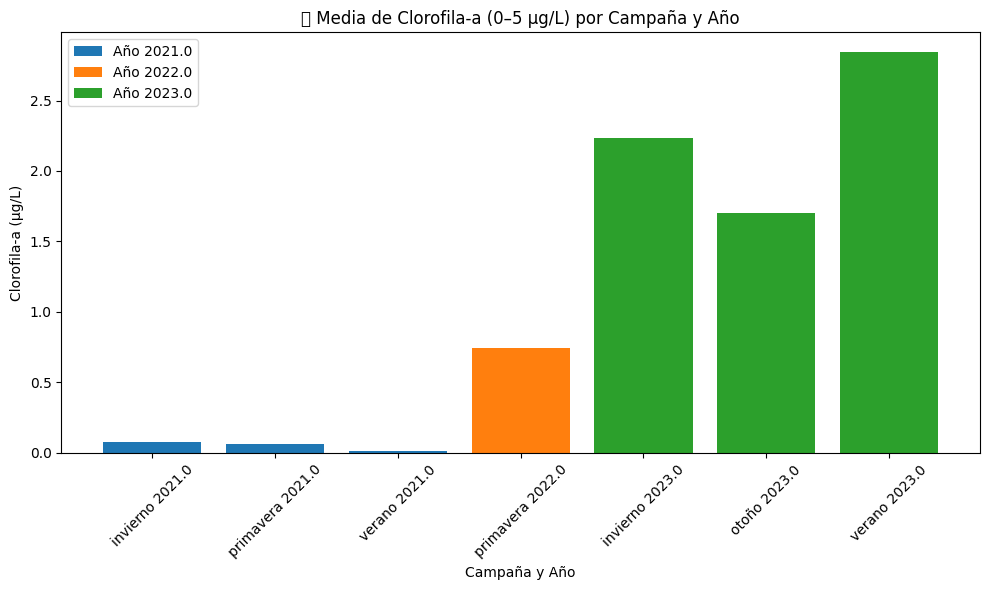

In [12]:
# --- 6. Gr√°fico de barras ---
fig, ax = plt.subplots(figsize=(10,6))

# Crear un gr√°fico agrupado por a√±o
for a√±o in estadisticas['a√±o'].unique():
    subset = estadisticas[estadisticas['a√±o'] == a√±o]
    ax.bar(
        subset['campa√±a'].astype(str) + " " + subset['a√±o'].astype(str),
        subset['media'],
        label=f"A√±o {a√±o}"
    )

ax.set_title("üìä Media de Clorofila-a (0‚Äì5 ¬µg/L) por Campa√±a y A√±o")
ax.set_ylabel("Clorofila-a (¬µg/L)")
ax.set_xlabel("Campa√±a y A√±o")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Durante el a√±o 2021 se registraron niveles extremadamente bajos de clorofila-a en todas las estaciones del a√±o, con valores promedio cercanos a 0.07 Œºg/L. Esta baja concentraci√≥n sugiere la presencia de aguas muy limpias, posiblemente con escasa actividad fitoplanct√≥nica o baja productividad primaria.

En el a√±o 2022 se observa un leve aumento en los niveles de clorofila-a, especialmente durante la primavera, lo que podr√≠a indicar condiciones ligeramente m√°s favorables para el desarrollo del fitoplancton en comparaci√≥n con el a√±o anterior.

Por √∫ltimo, el a√±o 2023 evidencia un incremento marcado en la concentraci√≥n de clorofila-a, alcanzando valores promedio significativamente m√°s altos en invierno (~2.23 Œºg/L) y verano (casi 2.84 Œºg/L). Este aumento podr√≠a estar asociado a una mayor actividad biol√≥gica, mayor disponibilidad de nutrientes, o condiciones ambientales propicias para el crecimiento de algas.

#### Combinaciones presentes ANTES y DESPU√âS del filtro 0- 5

In [13]:
def _norm_text_ser(s: pd.Series) -> pd.Series:
    s = s.astype("string").fillna("")
    # NFKD para quitar tildes ‚Üí ascii ‚Üí decode ‚Üí lower/strip/colapsar espacios
    s = s.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii", "ignore").decode("utf-8"))
    s = s.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return s

def inspeccionar_dataset(df_in, nombre_df="df"):
    print(f"\n================= {nombre_df}: COMBINACIONES ANTES DEL FILTRO =================")
    # Mostrar √∫nicos crudos sin tocar el df original
    try:
        print(df_in[['campa√±a','a√±o']].dropna().drop_duplicates().sort_values(['a√±o','campa√±a']).to_string(index=False))
    except Exception:
        # Si hay problemas de tipos/NaN mezclados
        print(df_in[['campa√±a','a√±o']].drop_duplicates().to_string(index=False))

    # Copia de trabajo para normalizar
    tmp = df_in.copy()

    # Normalizaciones
    tmp['campa√±a'] = _norm_text_ser(tmp['campa√±a'])
    tmp['a√±o'] = pd.to_numeric(tmp['a√±o'], errors='coerce').astype('Int64')

    # Asegurar clorofila num√©rica
    tmp['clorofila_a_ug_l'] = pd.to_numeric(tmp['clorofila_a_ug_l'], errors='coerce')

    # Filtro (0‚Äì5 ¬µg/L, campa√±as v√°lidas, a√±os 2021‚Äì2023)
    mask = (
        tmp['clorofila_a_ug_l'].notna() &
        (tmp['clorofila_a_ug_l'] > 0) & (tmp['clorofila_a_ug_l'] <= 5) &
        (tmp['campa√±a'].isin(['invierno','primavera','oto√±o','verano'])) &
        (tmp['a√±o'].isin([2021, 2022, 2023]))
    )
    filtrado = tmp.loc[mask].copy()

    print(f"\n================= {nombre_df}: COMBINACIONES DESPU√âS DEL FILTRO (0‚Äì5 ¬µg/L) =================")
    if filtrado.empty:
        print("‚Äî (sin filas que cumplan el filtro)")
    else:
        print(filtrado[['campa√±a','a√±o']].drop_duplicates().sort_values(['a√±o','campa√±a']).to_string(index=False))

    # Conteo por a√±o x campa√±a
    print(f"\n================= {nombre_df}: CONTEO POR A√ëO x CAMPA√ëA (0‚Äì5 ¬µg/L) =================")
    if filtrado.empty:
        print("‚Äî (sin datos)")
    else:
        tabla = pd.crosstab(filtrado['a√±o'], filtrado['campa√±a']).fillna(0).astype(int)
        print(tabla)

# --- Ejecutar para el dataset original ---
inspeccionar_dataset(df, "df (original)")

# --- Ejecutar para el dataset nuevo (si existe) ---
try:
    df_nuevo  # verificar existencia
    inspeccionar_dataset(df_nuevo, "df_nuevo")
except NameError:
    print("\n[Aviso] 'df_nuevo' no est√° definido en este entorno. Primero gener√° el dataset nuevo.")




================= df (original): COMBINACIONES ANTES DEL FILTRO =================
  campa√±a    a√±o
 invierno 2021.0
    oto√±o 2021.0
primavera 2021.0
   verano 2021.0
 invierno 2022.0
    oto√±o 2022.0
primavera 2022.0
   verano 2022.0
 invierno 2023.0
    oto√±o 2023.0
primavera 2023.0
   verano 2023.0
primavera 2024.0
   verano 2024.0

================= df (original): COMBINACIONES DESPU√âS DEL FILTRO (0‚Äì5 ¬µg/L) =================
  campa√±a  a√±o
 invierno 2021
primavera 2021
   verano 2021
primavera 2022
 invierno 2023
   verano 2023

================= df (original): CONTEO POR A√ëO x CAMPA√ëA (0‚Äì5 ¬µg/L) =================
campa√±a  invierno  primavera  verano
a√±o                                 
2021            5         29      23
2022            0         15       0
2023           20          0       6

================= df_nuevo: COMBINACIONES ANTES DEL FILTRO =================
  campa√±a    a√±o
 invierno 2021.0
primavera 2021.0
   verano 2021.0
 invierno 2022.0
    o

Se implement√≥ un proceso  de inspecci√≥n y limpieza de datos para asegurar la calidad y consistencia del conjunto de datos original.
Las campa√±as estacionales se normalizaron usando Unicode normalization (NFKD) para eliminar acentos y garantizar la uniformidad textual.
Las columnas de a√±o y clorofila-a se convierten a valores num√©ricos, descartando entradas inv√°lidas.
Se aplica un filtro que conserva solo aquellos registros que cumplen simult√°neamente con: A√±os entre 2021 y 2023; campa√±as definidas como "invierno", "primavera", "verano" u "oto√±o" y valores de clorofila-a dentro del rango 0‚Äì5 ¬µg/L

### *Valores entre 5-100 ‚ÄØ¬µg/L*


In [14]:
# --- Filtrar clorofila entre 5 y 100 ¬µg/L ---
df_filtrado = df_nuevo[
    (df_nuevo['clorofila_a_ug_l'] >= 5) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Mostrar cantidad de datos ---
print(f"Cantidad de datos en rango 5‚Äì100 ¬µg/L: {len(df_filtrado)}")

# --- Calcular estad√≠sticas ---
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std'])
estadisticas = estadisticas.rename({
    'mean': 'media',
    'min': 'm√≠n',
    'max': 'm√°x',
    'std': 'desv√≠o est√°ndar'
})

print("\n Estad√≠sticas de clorofila_a_ug_l (¬µg/L):")
print(estadisticas)

# --- Seleccionar columnas relevantes ---
columnas = ['clorofila_a_ug_l', 'campa√±a', 'a√±o', 'latitud', 'longitud']

# --- Mostrar las filas filtradas con esas columnas ---
print("\nMuestras en rango 5‚Äì100 ¬µg/L:")
print(df_filtrado[columnas].reset_index(drop=True))


Cantidad de datos en rango 5‚Äì100 ¬µg/L: 99

 Estad√≠sticas de clorofila_a_ug_l (¬µg/L):
media              26.552727
m√≠n                 5.520000
m√°x                94.810000
desv√≠o est√°ndar    21.190029
Name: clorofila_a_ug_l, dtype: float64

Muestras en rango 5‚Äì100 ¬µg/L:
    clorofila_a_ug_l    campa√±a     a√±o      latitud     longitud
0               20.7     verano  2022.0          NaN          NaN
1                8.2  primavera  2022.0          NaN          NaN
2               40.9  primavera  2022.0  -34.662.789  -58.296.669
3               70.8     verano  2022.0       -34.63  -58.328.339
4                6.4  primavera  2022.0       -34.63  -58.328.339
..               ...        ...     ...          ...          ...
94              10.3     verano  2024.0          NaN          NaN
95              26.0  primavera  2024.0          NaN          NaN
96              17.0  primavera  2024.0          NaN          NaN
97              11.0        nan     NaN          NaN   

### *Valores entre 100-6500 ‚ÄØ¬µg/L*

In [15]:
# --- Asegurar que la columna es num√©rica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar valores v√°lidos num√©ricos entre 100 y 6500 ¬µg/L ---
df_filtrado = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 100) &
    (df_nuevo['clorofila_a_ug_l'] <= 6500)
].copy()

# --- Mostrar cantidad de valores que cumplen el filtro ---
print(f"Cantidad de valores v√°lidos entre 100 y 6500 ¬µg/L: {len(df_filtrado)}")

# --- Calcular estad√≠sticas ---
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std'])
estadisticas = estadisticas.rename({
    'mean': 'media',
    'min': 'm√≠n',
    'max': 'm√°x',
    'std': 'desv√≠o est√°ndar'
})

print("\n Estad√≠sticas de clorofila_a_ug_l (¬µg/L):")
print(estadisticas)

# --- Seleccionar columnas relevantes ---
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campa√±a', 'a√±o']

# Si hay suficientes filas, tomar una muestra aleatoria de 10
if len(df_filtrado) >= 10:
    muestra = df_filtrado[columnas].sample(n=10, random_state=42)
else:
    muestra = df_filtrado[columnas]

# --- Mostrar resultado ---
print("\nMuestra de valores en rango 100‚Äì6500 ¬µg/L:")
print(muestra.reset_index(drop=True))


Cantidad de valores v√°lidos entre 100 y 6500 ¬µg/L: 39

 Estad√≠sticas de clorofila_a_ug_l (¬µg/L):
media              1042.379744
m√≠n                 101.820000
m√°x                6410.000000
desv√≠o est√°ndar    1367.102117
Name: clorofila_a_ug_l, dtype: float64

Muestra de valores en rango 100‚Äì6500 ¬µg/L:
   clorofila_a_ug_l      latitud     longitud   campa√±a     a√±o
0            174.32  -34.744.169  -58.177.231    verano  2023.0
1            101.82          NaN          NaN    verano  2023.0
2            870.00       -34.63  -58.328.339  invierno  2022.0
3           1400.00  -34.744.169  -58.177.231  invierno  2022.0
4            740.00  -34.505.531  -58.473.719  invierno  2022.0
5           1030.00          NaN          NaN     oto√±o  2022.0
6           1730.00  -34.873.061  -57.810.561  invierno  2022.0
7            760.00          NaN          NaN  invierno  2022.0
8           1290.00  -34.833.911  -57.880.211  invierno  2022.0
9           2500.00      -34.753  -58.108.

### Rango 0 a 100 ug/l

/tmp/ipython-input-3957413295.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle0 = plt.Circle((0,0), 1, color='white', edgecolor='black', lw=1, label='0')


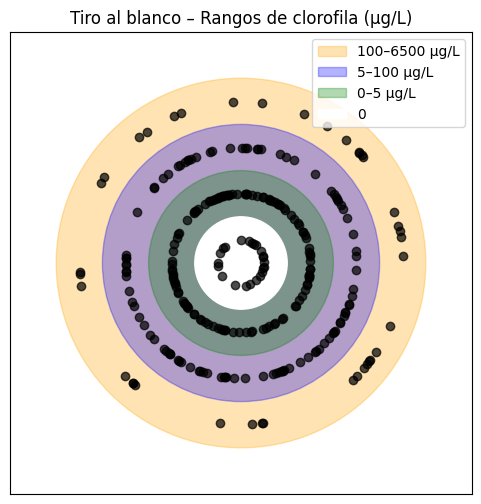

In [16]:
# --- Partir de df_nuevo ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')
df_validos = df_nuevo[df_nuevo['clorofila_a_ug_l'].notna()].copy()

# Categorizar cada valor en un rango
def categorizar(valor):
    if valor == 0:
        return "0"
    elif 0 < valor <= 5:
        return "0‚Äì5"
    elif 5 < valor <= 100:
        return "5‚Äì100"
    elif 100 < valor <= 6500:
        return "100‚Äì6500"
    else:
        return "Fuera de rango"

df_validos["rango"] = df_validos["clorofila_a_ug_l"].apply(categorizar)

# --- Gr√°fico de tiro al blanco ---
fig, ax = plt.subplots(figsize=(6,6))

# C√≠rculos conc√©ntricos que representan los rangos
circle0 = plt.Circle((0,0), 1, color='white', edgecolor='black', lw=1, label='0')
circle1 = plt.Circle((0,0), 2, color='green', alpha=0.3, label='0‚Äì5 ¬µg/L')
circle2 = plt.Circle((0,0), 3, color='blue', alpha=0.3, label='5‚Äì100 ¬µg/L')
circle3 = plt.Circle((0,0), 4, color='orange', alpha=0.3, label='100‚Äì6500 ¬µg/L')

for c in [circle3, circle2, circle1, circle0]:
    ax.add_artist(c)

# Ubicar puntos de cada registro (aleatorios en √°ngulo para que no se encimen)
np.random.seed(42)
for _, row in df_validos.iterrows():
    r = {"0":0.5, "0‚Äì5":1.5, "5‚Äì100":2.5, "100‚Äì6500":3.5, "Fuera de rango":4.5}[row["rango"]]
    theta = np.random.uniform(0, 2*np.pi)
    ax.plot(r*np.cos(theta), r*np.sin(theta), 'o',
            color='red' if row["rango"]=="Fuera de rango" else 'black', alpha=0.7)

# Est√©tica
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Tiro al blanco ‚Äì Rangos de clorofila (¬µg/L)")
ax.legend(loc="upper right")

plt.show()


El resultado es un dataset de 277 datos, se considera tomar todos los valores de 0 a 100 ug/l en base al analisis anterior dando lugar a un total de 215 datos. Se deja por fuera tambien los valores igual a 0.  

#### Estadisticas del rango de 0 a 100

In [17]:
# --- Asegurar que la columna es num√©rica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar rango 0‚Äì100 ¬µg/L (excluyendo 0 si quer√©s) ---
valores = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
]['clorofila_a_ug_l']

# --- Calcular estad√≠sticas ---
estadisticas = valores.agg([
    'count',   # cantidad total
    'mean',    # media
    'median',  # mediana
    'min',     # m√≠nimo
    'max',     # m√°ximo
    'std'      # desviaci√≥n est√°ndar
]).rename({
    'count': 'Cantidad',
    'mean': 'Media',
    'median': 'Mediana',
    'min': 'M√≠nimo',
    'max': 'M√°ximo',
    'std': 'Desv√≠o est√°ndar'
})

# --- Calcular percentiles adicionales ---
percentiles = valores.quantile([0.25, 0.75])
estadisticas['Percentil 25%'] = percentiles.loc[0.25]
estadisticas['Percentil 75%'] = percentiles.loc[0.75]

print(" Estad√≠sticas descriptivas de clorofila_a_ug_l en el rango 0‚Äì100 ¬µg/L:")
print(estadisticas)

 Estad√≠sticas descriptivas de clorofila_a_ug_l en el rango 0‚Äì100 ¬µg/L:
Cantidad           215.000000
Media               12.720766
Mediana              3.450000
M√≠nimo               0.000590
M√°ximo              94.810000
Desv√≠o est√°ndar     19.249618
Percentil 25%        0.120680
Percentil 75%       17.410000
Name: clorofila_a_ug_l, dtype: float64


Se analiza la cantidad de valores con coordenadas

In [18]:
# --- Asegurar que la columna de clorofila es num√©rica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar valores en el rango 0‚Äì100 ¬µg/L ---
df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Filtrar los que adem√°s tienen latitud y longitud v√°lidos ---
df_rango_coords = df_rango[
    df_rango['latitud'].notna() & df_rango['longitud'].notna()
]

# --- Contar ---
total_en_rango = len(df_rango)
con_coords = len(df_rango_coords)

print(f" Total de datos en rango 0‚Äì100 ¬µg/L: {total_en_rango}")
print(f" De esos, tienen latitud y longitud v√°lidos: {con_coords}")

# (Opcional) mostrar las primeras filas con coordenadas
print("\nEjemplos con coordenadas:")
print(df_rango_coords[['clorofila_a_ug_l', 'latitud', 'longitud']].head(10))

 Total de datos en rango 0‚Äì100 ¬µg/L: 215
 De esos, tienen latitud y longitud v√°lidos: 89

Ejemplos con coordenadas:
    clorofila_a_ug_l      latitud     longitud
4            0.04331  -34.662.789  -58.296.669
6            0.00119       -34.63  -58.328.339
9            0.00500  -34.873.061  -57.810.561
10           0.00700  -34.855.808  -57.838.144
11           0.06289  -34.855.808  -57.838.144
20           0.05300  -34.744.169  -58.177.231
21           0.21265  -34.744.169  -58.177.231
22           0.06100      -34.753  -58.108.281
23           0.22100      -34.753  -58.108.281
24           0.84016      -34.753  -58.108.281


Se observa un resumen del filtrado y georreferenciaci√≥n de los datos de clorofila-a dentro del rango v√°lido de 0 a 100‚ÄØ¬µg/L. En total, se identificaron 215 muestras que cumplen ese criterio. De esas, 89 registros cuentan con coordenadas geogr√°ficas v√°lidas de latitud y longitud.

Adem√°s, se listan algunos ejemplos de esas muestras con coordenadas v√°lidas, mostrando los valores de clorofila-a y su ubicaci√≥n geogr√°fica asociada. Esto permite verificar la integridad de los datos espaciales y confirmar que hay diversidad de puntos de muestreo distribuidos en la regi√≥n de estudio.

Normalizar la latitud y longuitud

In [27]:

def _fix_decimal_dots(s: str) -> str:
    """
    Mantiene solo el primer punto decimal en la cadena.
    - Reemplaza comas por punto.
    - Si hay >1 punto, conserva el primero y elimina los dem√°s.
    - Elimina espacios.
    """
    if s is None:
        return None
    s = str(s).strip().replace(',', '.')
    # Si no hay varios puntos, devolver tal cual
    if s.count('.') <= 1:
        return s
    # Mantener solo el primer punto
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

# 1) Crear columnas normalizadas (no pisamos las originales)
df_nuevo['latitud_norm']  = df_nuevo['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
df_nuevo['longitud_norm'] = df_nuevo['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

# 2) Validar rangos geogr√°ficos
mask_lat_ok = df_nuevo['latitud_norm'].between(-90, 90)
mask_lon_ok = df_nuevo['longitud_norm'].between(-180, 180)
mask_coords_ok = mask_lat_ok & mask_lon_ok

# 3) Filtrar clorofila en 0‚Äì100 ¬µg/L y contar con coords v√°lidas
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

df_rango_coords_ok = df_rango[mask_coords_ok.reindex(df_rango.index, fill_value=False)]

print(f"Total de datos en rango 0‚Äì100 ¬µg/L: {len(df_rango)}")
print(f"Con coordenadas v√°lidas tras normalizar: {len(df_rango_coords_ok)}")

# 4) Ver algunos ejemplos antes/despu√©s
ej = df_rango_coords_ok[['latitud','latitud_norm','longitud','longitud_norm']].head(10).reset_index(drop=True)
print("\nEjemplos de normalizaci√≥n de coordenadas:")
print(ej)
salida = "clorofila_coords_ok.csv"
df_rango_coords_ok.to_csv(salida, index=False, encoding="utf-8")

print(f"Archivo exportado correctamente: {salida}")

Total de datos en rango 0‚Äì100 ¬µg/L: 215
Con coordenadas v√°lidas tras normalizar: 89

Ejemplos de normalizaci√≥n de coordenadas:
       latitud  latitud_norm     longitud  longitud_norm
0  -34.662.789    -34.662789  -58.296.669     -58.296669
1       -34.63    -34.630000  -58.328.339     -58.328339
2  -34.873.061    -34.873061  -57.810.561     -57.810561
3  -34.855.808    -34.855808  -57.838.144     -57.838144
4  -34.855.808    -34.855808  -57.838.144     -57.838144
5  -34.744.169    -34.744169  -58.177.231     -58.177231
6  -34.744.169    -34.744169  -58.177.231     -58.177231
7      -34.753    -34.753000  -58.108.281     -58.108281
8      -34.753    -34.753000  -58.108.281     -58.108281
9      -34.753    -34.753000  -58.108.281     -58.108281
Archivo exportado correctamente: clorofila_coords_ok.csv


Se realiz√≥ una normalizaci√≥n de las coordenadas geogr√°ficas para asegurar que los valores de latitud y longitud fueran interpretables como n√∫meros decimales v√°lidos. Originalmente, los datos conten√≠an puntos decimales mal posicionados o formatos incorrectos (por ejemplo, -34.662.789), lo cual imped√≠a su correcto uso en an√°lisis espaciales o visualizaci√≥n en mapas.Luego de aplicar la transformaci√≥n, se conservaron 215 registros dentro del rango v√°lido de clorofila-a (0 a 100‚ÄØ¬µg/L). De esos, 89 ten√≠an coordenadas que pudieron ser normalizadas correctamente, y por tanto quedaron aptas para ser representadas espacialmente.

Agrego la fecha

In [28]:
import pandas as pd
import re
from datetime import datetime

def _fix_decimal_dots(s: str) -> str:
    """Normaliza separadores decimales en coordenadas."""
    if pd.isna(s):
        return None
    s = str(s).strip().replace(',', '.')
    if s.count('.') <= 1:
        return s
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

def _normalize_fecha(col_fecha: pd.Series, col_anio=None, col_mes=None, col_dia=None) -> pd.Series:
    """
    Devuelve fechas normalizadas 'YYYY-MM-DD'.
    - Intenta parseo directo con varios formatos (dayfirst=True).
    - Si falla y hay a√±o/mes/d√≠a, arma la fecha desde esas columnas.
    """
    f = None
    if col_fecha is not None and col_fecha.name in col_fecha.index.to_series().index or True:
        # 1) Intento directo con to_datetime (robusto)
        s = col_fecha.astype('string').fillna('').str.strip()
        # Reparaciones r√°pidas: reemplazar puntos por guiones en fechas tipo 2021.07.03
        s = s.str.replace(r'[\u200b]', '', regex=True)  # zero-width
        s_try = s.str.replace(r'\.', '-', regex=True).str.replace(r'/', '-', regex=True)

        f = pd.to_datetime(s_try, errors='coerce', dayfirst=True, utc=False)

        # 2) Si siguen NaT y tengo Y/M/D, armo
        if (f.isna().any()) and (col_anio is not None and col_mes is not None and col_dia is not None):
            y = pd.to_numeric(col_anio, errors='coerce')
            m = pd.to_numeric(col_mes, errors='coerce')
            d = pd.to_numeric(col_dia, errors='coerce')
            mask_build = f.isna() & y.notna() & m.notna() & d.notna()
            f.loc[mask_build] = pd.to_datetime(
                dict(year=y[mask_build].astype(int),
                     month=m[mask_build].astype(int),
                     day=d[mask_build].astype(int)),
                errors='coerce'
            )
    else:
        # No hay columna fecha: intentar construir desde Y/M/D si existen
        if (col_anio is not None and col_mes is not None and col_dia is not None):
            y = pd.to_numeric(col_anio, errors='coerce')
            m = pd.to_numeric(col_mes, errors='coerce')
            d = pd.to_numeric(col_dia, errors='coerce')
            f = pd.to_datetime(dict(year=y, month=m, day=d), errors='coerce')
        else:
            f = pd.Series(pd.NaT, index=col_fecha.index if col_fecha is not None else None)

    # Normalizar a string ISO
    fecha_norm = f.dt.strftime('%Y-%m-%d')
    return fecha_norm

# --- Normalizar coordenadas ---
df_nuevo['latitud_norm']  = df_nuevo['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
df_nuevo['longitud_norm'] = df_nuevo['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

# --- Validar rangos geogr√°ficos ---
mask_lat_ok = df_nuevo['latitud_norm'].between(-90, 90)
mask_lon_ok = df_nuevo['longitud_norm'].between(-180, 180)
mask_coords_ok = mask_lat_ok & mask_lon_ok

# --- Asegurar clorofila num√©rica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Normalizar FECHA (usa 'fecha' si existe; si no, intenta 'a√±o','mes','dia'/'d√≠a') ---
col_mes = df_nuevo['mes'] if 'mes' in df_nuevo.columns else (df_nuevo['Mes'] if 'Mes' in df_nuevo.columns else None)
col_dia = (df_nuevo['d√≠a'] if 'd√≠a' in df_nuevo.columns else
           df_nuevo['dia'] if 'dia' in df_nuevo.columns else
           df_nuevo['Dia'] if 'Dia' in df_nuevo.columns else None)

df_nuevo['fecha_norm'] = _normalize_fecha(
    df_nuevo['fecha'] if 'fecha' in df_nuevo.columns else pd.Series([None]*len(df_nuevo)),
    col_anio=df_nuevo['a√±o'] if 'a√±o' in df_nuevo.columns else (df_nuevo['anio'] if 'anio' in df_nuevo.columns else None),
    col_mes=col_mes,
    col_dia=col_dia
)

# --- Filtrar rango de clorofila (0‚Äì100 ¬µg/L) ---
df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Mantener solo registros con coordenadas v√°lidas ---
dataset_muestra_coordenadas = df_rango[mask_coords_ok.reindex(df_rango.index, fill_value=False)].copy()

# --- Reemplazar columnas originales por las normalizadas ---
dataset_muestra_coordenadas['latitud']  = dataset_muestra_coordenadas['latitud_norm']
dataset_muestra_coordenadas['longitud'] = dataset_muestra_coordenadas['longitud_norm']
dataset_muestra_coordenadas = dataset_muestra_coordenadas.drop(columns=['latitud_norm','longitud_norm'])

# --- Seleccionar columnas relevantes (incluye fecha normalizada) ---
cols_existentes = [c for c in ['clorofila_a_ug_l','campa√±a','a√±o','fecha_norm','latitud','longitud'] if c in dataset_muestra_coordenadas.columns]
dataset_muestra_coordenadas = dataset_muestra_coordenadas[cols_existentes]

# --- Verificar ---
print(f"üìä Nuevo dataset creado: {len(dataset_muestra_coordenadas)} filas con clorofila + campa√±a + a√±o + fecha_norm + coords normalizadas")
print(dataset_muestra_coordenadas.head(10))

üìä Nuevo dataset creado: 89 filas con clorofila + campa√±a + a√±o + fecha_norm + coords normalizadas
    clorofila_a_ug_l    campa√±a     a√±o  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.84016  primavera  2021.0  2021-10-27 -34.753000 -58.108281


La incorporaci√≥n del campo fecha_norm responde a la necesidad de tener un control temporal m√°s preciso del momento en que fueron tomadas las muestras, superando la ambig√ºedad que puede implicar trabajar solo con a√±o y campa√±a (estaci√≥n). Esto permite asociar las muestras a im√°genes satelitales con fechas espec√≠ficas, evaluar tendencias temporales m√°s finas y mejorar la trazabilidad de los datos.
Se cre√≥ un nuevo dataset refinado que integra los valores de clorofila-a, la estaci√≥n del a√±o, el a√±o de muestreo, la fecha exacta de recolecci√≥n y las coordenadas geogr√°ficas normalizadas (latitud y longitud) de las muestras

Nuevo dataset

dataset_muestra_coordenadas

In [29]:
def _fix_decimal_dots(s: str) -> str:
    """
    Normaliza separadores decimales:
    - Reemplaza comas por punto.
    - Si hay m√°s de un punto, mantiene solo el primero.
    - Elimina espacios.
    """
    if pd.isna(s):
        return None
    s = str(s).strip().replace(',', '.')
    if s.count('.') <= 1:
        return s
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

def _normalize_fecha(df):
    """
    Normaliza fechas:
    - Usa la columna 'fecha' si existe (parseo flexible).
    - Si no existe, intenta armar fecha desde a√±o/mes/d√≠a.
    """
    if 'fecha' in df.columns:
        fechas = pd.to_datetime(df['fecha'], errors='coerce', dayfirst=True)
    elif all(c in df.columns for c in ['a√±o','mes','dia']):
        fechas = pd.to_datetime(dict(year=df['a√±o'], month=df['mes'], day=df['dia']), errors='coerce')
    else:
        fechas = pd.NaT
    return fechas.dt.strftime('%Y-%m-%d')

# --- Normalizar coordenadas ---
df_nuevo['latitud_norm']  = df_nuevo['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
df_nuevo['longitud_norm'] = df_nuevo['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

# --- Validar rangos geogr√°ficos ---
mask_lat_ok = df_nuevo['latitud_norm'].between(-90, 90)
mask_lon_ok = df_nuevo['longitud_norm'].between(-180, 180)
mask_coords_ok = mask_lat_ok & mask_lon_ok

# --- Asegurar clorofila num√©rica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Agregar columna de fecha normalizada ---
df_nuevo['fecha_norm'] = _normalize_fecha(df_nuevo)

# --- Filtrar rango de clorofila (0‚Äì100 ¬µg/L) ---
df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Mantener solo registros con coordenadas v√°lidas ---
dataset_muestra_coordenadas = df_rango[mask_coords_ok.reindex(df_rango.index, fill_value=False)].copy()

# --- Reemplazar columnas originales por las normalizadas ---
dataset_muestra_coordenadas['latitud']  = dataset_muestra_coordenadas['latitud_norm']
dataset_muestra_coordenadas['longitud'] = dataset_muestra_coordenadas['longitud_norm']
dataset_muestra_coordenadas = dataset_muestra_coordenadas.drop(columns=['latitud_norm','longitud_norm'])

# --- Seleccionar columnas relevantes ---
dataset_muestra_coordenadas = dataset_muestra_coordenadas[
    ['clorofila_a_ug_l', 'campa√±a', 'a√±o', 'fecha_norm', 'latitud', 'longitud']
]

# --- Verificar ---
print(f" Nuevo dataset creado: {len(dataset_muestra_coordenadas)} filas con clorofila + campa√±a + a√±o + fecha_norm + coords normalizadas")
print(dataset_muestra_coordenadas.head(10))


 Nuevo dataset creado: 89 filas con clorofila + campa√±a + a√±o + fecha_norm + coords normalizadas
    clorofila_a_ug_l    campa√±a     a√±o  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.84016  primavera  2021.0  2021-10-27 -34.753000 -58.108281


Maximo y minimo de clorofila

In [30]:
# --- Imprimir valores extremos de clorofila ---
if not dataset_muestra_coordenadas['clorofila_a_ug_l'].empty:
    min_val = dataset_muestra_coordenadas['clorofila_a_ug_l'].min()
    max_val = dataset_muestra_coordenadas['clorofila_a_ug_l'].max()
    print(f"\n Valor m√≠nimo de clorofila-a: {min_val:.5f} ¬µg/L")
    print(f" Valor m√°ximo de clorofila-a: {max_val:.5f} ¬µg/L")
else:
    print("\n No hay datos de clorofila v√°lidos para calcular extremos.")



 Valor m√≠nimo de clorofila-a: 0.00059 ¬µg/L
 Valor m√°ximo de clorofila-a: 92.40000 ¬µg/L


####  Se analiza la cantidad de valores entre 0 y 1

La elecci√≥n del rango entre 0 y 1 ¬µg/L de clorofila-a responde a criterios ecol√≥gicos y metodol√≥gicos asociados a la caracterizaci√≥n de la calidad del agua y la productividad biol√≥gica en cuerpos de agua. Este intervalo corresponde a niveles oligotr√≥ficos, es decir, condiciones de muy baja concentraci√≥n de fitoplancton y alta transparencia del agua, t√≠picas de ambientes limpios o con escasa productividad biol√≥gica. Trabajar en este rango permite detectar variaciones sutiles en la biomasa algal, especialmente en contextos donde los valores son muy bajos, como se observa en las campa√±as del a√±o 2021.Desde el punto de vista limnol√≥gico, los niveles de clorofila-a inferiores a 1 ¬µg/L reflejan un sistema con bajos aportes de nutrientes o con condiciones f√≠sico-qu√≠micas que limitan el desarrollo del fitoplancton, como pueden ser la baja temperatura, la alta turbidez no algal o la influencia de masas de agua m√°s limpias. Por lo tanto, al centrar el an√°lisis en este rango, se pueden identificar de forma precisa los umbrales a partir de los cuales comienza a aumentar la actividad biol√≥gica en el sistema, lo que es fundamental para estudios de evoluci√≥n temporal, detecci√≥n de cambios interanuales o calibraci√≥n de modelos satelitales sensibles a bajas concentraciones de clorofila.
Cuando se trabaja con √≠ndices satelitales como el NDCI, la sensibilidad del modelo en rangos bajos puede verse afectada por saturaci√≥n espectral o por ruido radiom√©trico. En consecuencia, disponer de datos in situ confiables dentro del rango 0‚Äì1 ¬µg/L es esencial para validar y ajustar modelos de estimaci√≥n remota en condiciones de baja biomasa. Este enfoque permite establecer una l√≠nea de base robusta para futuras comparaciones, detectar condiciones an√≥malas y caracterizar las transiciones hacia estados m√°s productivos del ecosistema.

In [31]:
# Aseguramos que la columna es num√©rica
dataset_muestra_coordenadas['clorofila_a_ug_l'] = pd.to_numeric(
    dataset_muestra_coordenadas['clorofila_a_ug_l'], errors='coerce'
)

# Filtrar rango (0‚Äì1 ¬µg/L, excluyendo ceros exactos si no los quer√©s)
df_0_1 = dataset_muestra_coordenadas[
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] > 0) &
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] <= 1)
]

# Cantidad total
print(f" Cantidad de valores entre 0 y 1 ¬µg/L: {len(df_0_1)}")

# Mostrar ejemplos
print(df_0_1.head(10))


 Cantidad de valores entre 0 y 1 ¬µg/L: 39
    clorofila_a_ug_l    campa√±a     a√±o  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.84016  primavera  2021.0  2021-10-27 -34.753000 -58.108281


Etadistica de los valores del rango 0-1

In [32]:
# Asegurar que la columna sea num√©rica
dataset_muestra_coordenadas['clorofila_a_ug_l'] = pd.to_numeric(
    dataset_muestra_coordenadas['clorofila_a_ug_l'], errors='coerce'
)

# Filtrar rango (0‚Äì1 ¬µg/L, excluyendo ceros si no quer√©s)
df_0_1 = dataset_muestra_coordenadas[
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] > 0) &
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] <= 1)
]

# Cantidad total
print(f"üîé Cantidad de valores entre 0 y 1 ¬µg/L: {len(df_0_1)}")

# Estad√≠sticas descriptivas
estadisticas = df_0_1['clorofila_a_ug_l'].agg(
    media='mean',
    m√≠nimo='min',
    m√°ximo='max',
    mediana='median',
    desv√≠o_std='std'
)

print("\n Estad√≠sticas de valores 0‚Äì1 ¬µg/L:")
print(estadisticas)

# Mostrar primeras filas
print("\n Ejemplos:")
print(df_0_1[['clorofila_a_ug_l','campa√±a','a√±o','fecha_norm','latitud','longitud']].head(10))


üîé Cantidad de valores entre 0 y 1 ¬µg/L: 39

 Estad√≠sticas de valores 0‚Äì1 ¬µg/L:
media         0.168001
m√≠nimo        0.000590
m√°ximo        0.870000
mediana       0.035000
desv√≠o_std    0.250508
Name: clorofila_a_ug_l, dtype: float64

 Ejemplos:
    clorofila_a_ug_l    campa√±a     a√±o  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24

nuevo dataset

In [33]:
# Asegurar que la columna sea num√©rica
dataset_muestra_coordenadas['clorofila_a_ug_l'] = pd.to_numeric(
    dataset_muestra_coordenadas['clorofila_a_ug_l'], errors='coerce'
)

# Crear nuevo DataFrame con rango 0‚Äì1 ¬µg/L
rango_0_1 = dataset_muestra_coordenadas[
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] > 0) &
    (dataset_muestra_coordenadas['clorofila_a_ug_l'] <= 1)
].copy()

# Verificar
print(f"‚úÖ Nuevo DataFrame creado: {len(rango_0_1)} filas entre 0 y 1 ¬µg/L")
print(rango_0_1.head(10))


‚úÖ Nuevo DataFrame creado: 39 filas entre 0 y 1 ¬µg/L
    clorofila_a_ug_l    campa√±a     a√±o  fecha_norm    latitud   longitud
4            0.04331  primavera  2021.0  2021-10-27 -34.662789 -58.296669
6            0.00119  primavera  2021.0  2021-10-27 -34.630000 -58.328339
9            0.00500     verano  2021.0  2021-02-24 -34.873061 -57.810561
10           0.00700     verano  2021.0  2021-02-24 -34.855808 -57.838144
11           0.06289  primavera  2021.0  2021-10-27 -34.855808 -57.838144
20           0.05300     verano  2021.0  2021-02-24 -34.744169 -58.177231
21           0.21265  primavera  2021.0  2021-10-27 -34.744169 -58.177231
22           0.06100     verano  2021.0  2021-02-24 -34.753000 -58.108281
23           0.22100   invierno  2021.0  2021-08-25 -34.753000 -58.108281
24           0.84016  primavera  2021.0  2021-10-27 -34.753000 -58.108281


Mapa de los puntos rango 0-1

 Total en 0‚Äì100 ¬µg/L: 215
 Con coordenadas v√°lidas: 89
   ‚îú‚îÄ 0‚Äì1 ¬µg/L (con coords): 39
   ‚îî‚îÄ 1‚Äì100 ¬µg/L (con coords): 50


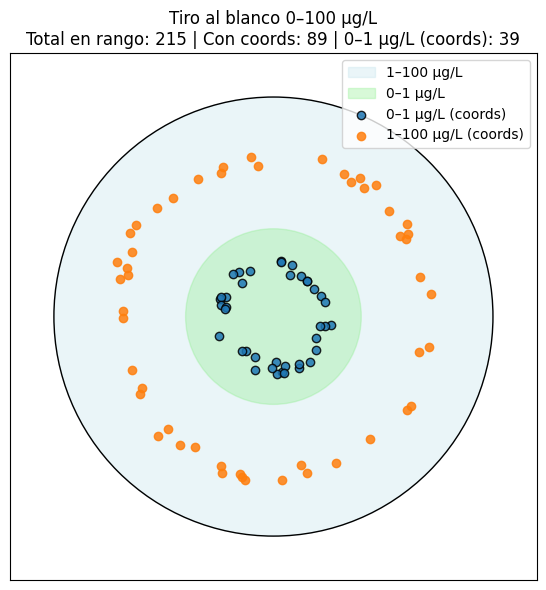

In [35]:

# --- Asegurar clorofila num√©rica ---
df_nuevo['clorofila_a_ug_l'] = pd.to_numeric(df_nuevo['clorofila_a_ug_l'], errors='coerce')

# --- Filtrar 0‚Äì100 ¬µg/L ---
df_rango = df_nuevo[
    df_nuevo['clorofila_a_ug_l'].notna() &
    (df_nuevo['clorofila_a_ug_l'] > 0) &
    (df_nuevo['clorofila_a_ug_l'] <= 100)
].copy()

# --- Con coordenadas v√°lidas ---
df_rango_coords = df_rango[
    df_rango['latitud'].notna() & df_rango['longitud'].notna()
].copy()

# --- Subconjunto 0‚Äì1 ¬µg/L dentro de los que tienen coords ---
df_0_1_coords = df_rango_coords[
    (df_rango_coords['clorofila_a_ug_l'] > 0) &
    (df_rango_coords['clorofila_a_ug_l'] <= 1)
].copy()

# --- Conteos ---
total_en_rango = len(df_rango)
con_coords = len(df_rango_coords)
n_0_1 = len(df_0_1_coords)
n_1_100 = con_coords - n_0_1

print(f" Total en 0‚Äì100 ¬µg/L: {total_en_rango}")
print(f" Con coordenadas v√°lidas: {con_coords}")
print(f"   ‚îú‚îÄ 0‚Äì1 ¬µg/L (con coords): {n_0_1}")
print(f"   ‚îî‚îÄ 1‚Äì100 ¬µg/L (con coords): {n_1_100}")

# --- Gr√°fico de tiro al blanco ---
fig, ax = plt.subplots(figsize=(6,6))

# C√≠rculo central (0‚Äì1 ¬µg/L) y anillo (1‚Äì100 ¬µg/L)
inner = plt.Circle((0,0), 1.0, fill=True, color='lightgreen', alpha=0.35, label='0‚Äì1 ¬µg/L')
outer = plt.Circle((0,0), 2.5, fill=True, color='lightblue',  alpha=0.25, label='1‚Äì100 ¬µg/L')
rim   = plt.Circle((0,0), 2.5, fill=False, edgecolor='black', lw=1)

ax.add_artist(outer)
ax.add_artist(inner)
ax.add_artist(rim)

# Distribuir puntos con coordenadas en los anillos
# (√°ngulo aleatorio; radio fijo por rango para el efecto "blanco")
rng = np.random.default_rng(42)

def plot_ring_points(df_points, radius, marker, label, edge=None, alpha=0.85):
    if len(df_points) == 0:
        return
    theta = rng.uniform(0, 2*np.pi, size=len(df_points))
    # peque√±o jitter radial para no superponer exacto
    r = radius + rng.uniform(-0.10, 0.10, size=len(df_points))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.scatter(x, y, s=36, marker=marker, alpha=alpha, edgecolor=edge, label=label)

# Puntos 0‚Äì1 ¬µg/L (centro)
plot_ring_points(df_0_1_coords, radius=0.6, marker='o', label='0‚Äì1 ¬µg/L (coords)', edge='black')

# Puntos 1‚Äì100 ¬µg/L (anillo)
df_1_100_coords = df_rango_coords.loc[~df_rango_coords.index.isin(df_0_1_coords.index)]
plot_ring_points(df_1_100_coords, radius=1.8, marker='o', label='1‚Äì100 ¬µg/L (coords)')

# Est√©tica del blanco
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])

ax.set_title(
    f"Tiro al blanco 0‚Äì100 ¬µg/L\n"
    f"Total en rango: {total_en_rango} | Con coords: {con_coords} | 0‚Äì1 ¬µg/L (coords): {n_0_1}"
)

# Leyenda ordenada y sin duplicados
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc='upper right')

plt.tight_layout()
plt.show()


In [36]:
# --- Asegurar columnas num√©ricas ---
rango_0_1['latitud'] = pd.to_numeric(rango_0_1['latitud'], errors='coerce')
rango_0_1['longitud'] = pd.to_numeric(rango_0_1['longitud'], errors='coerce')
rango_0_1 = rango_0_1.dropna(subset=['latitud', 'longitud', 'clorofila_a_ug_l'])

# --- Coordenadas de Buenos Aires (centro de la vista) ---
centro_bsas = [-34.6037, -58.3816]  # CABA

# --- Crear mapa centrado en Buenos Aires ---
m = folium.Map(
    location=centro_bsas,
    zoom_start=9,
    tiles=None  # Fondo personalizado
)

# --- Fondo satelital de Google ---
folium.TileLayer(
    tiles='http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

# --- Agregar puntos rojos con popup ---
for _, row in rango_0_1.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        popup=folium.Popup(
            f"<b>Clorofila-a:</b> {row['clorofila_a_ug_l']} ¬µg/L<br><b>Fecha:</b> {row['fecha_norm']}",
            max_width=250
        )
    ).add_to(m)

# --- Leyenda HTML ---
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    z-index: 9999;
    background-color: white;
    padding: 10px;
    border: 2px solid #ccc;
    border-radius: 5px;
    font-size: 14px;
">
    <b>Leyenda</b><br>
    üî¥ Punto rojo: ubicaci√≥n de muestra<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- T√≠tulo HTML ---
title_html = '''
    <h3 align="center" style="font-size:18px; margin-top:10px">
        Valores en el rango 0‚Äì1 ¬µg/L de clorofila-a
    </h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# --- Control de capas ---
folium.LayerControl().add_to(m)

# --- Mostrar mapa interactivo ---
m


### Agrego variables turbidez y temperatura


In [37]:
# Columnas de inter√©s
cols = ["fecha", "latitud", "longitud", "turbiedad_ntu", "tem_agua"]
dfx = df[cols].copy()

# A num√©rico turbidez/temperatura
dfx["turbiedad_ntu"] = pd.to_numeric(dfx["turbiedad_ntu"], errors="coerce")
dfx["tem_agua"] = pd.to_numeric(dfx["tem_agua"], errors="coerce")

def parse_coord(x: str, kind: str):
    """
    Normaliza coordenadas con formatos como:
    - '-34.662.789' -> -34.662789
    - '-34.63'      -> -34.63
    - '-58.328.339' -> -58.328339
    No redondea. Devuelve float o None si no es v√°lido.
    """
    if x is None:
        return None
    s = str(x).strip()
    if s.lower() in ("", "na", "nan", "none"):
        return None

    # unificar coma decimal a punto
    s = s.replace(",", ".")

    # si ya parece n√∫mero simple con un solo punto decimal, usar directo
    if s.count(".") == 1 and all(c in "-.0123456789" for c in s):
        try:
            val = float(s)
            return val
        except:
            pass

    # de lo contrario, quitar todo lo que no sea d√≠gito para reconstruir
    sign = -1 if s.startswith("-") else 1
    digits = re.sub(r"\D", "", s)  # solo d√≠gitos
    if len(digits) < 3:
        return None

    # En Argentina esper√°s ~ -34 (lat) y ~ -58 (lon) => 2 d√≠gitos antes del decimal
    int_len = 2
    try:
        val = float(digits[:int_len] + "." + digits[int_len:])
        val *= sign
    except:
        return None

    # Chequeo de rango geogr√°fico b√°sico
    if kind == "lat":
        if not (-90 <= val <= 90):
            return None
    elif kind == "lon":
        if not (-180 <= val <= 180):
            return None

    return val

# Normalizar lat/lon sin redondear
dfx.loc[:, "latitud"]  = dfx["latitud"].apply(lambda v: parse_coord(v, "lat"))
dfx.loc[:, "longitud"] = dfx["longitud"].apply(lambda v: parse_coord(v, "lon"))

# Filtrar filas completas (todas las columnas con dato v√°lido)
df_validos = dfx.dropna(subset=["fecha", "latitud", "longitud", "turbiedad_ntu", "tem_agua"]).copy()

print("Registros v√°lidos y completos:", len(df_validos))
print(df_validos.head(10))

Registros v√°lidos y completos: 208
         fecha    latitud   longitud  turbiedad_ntu  tem_agua
8    24/2/2021 -34.662789 -58.296669           21.0      26.1
10   25/8/2021 -34.662789 -58.296669           21.0      14.7
11  27/10/2021 -34.662789 -58.296669           10.0      26.0
12   24/2/2021     -34.63 -58.328339           45.0      26.1
13   19/5/2021     -34.63 -58.328339           36.0      16.8
14   25/8/2021     -34.63 -58.328339           22.0      15.4
15  27/10/2021     -34.63 -58.328339           14.0      21.4
20   24/2/2021 -34.873061 -57.810561           18.0      20.0
22   25/8/2021 -34.873061 -57.810561            8.7      10.0
23  27/10/2021 -34.873061 -57.810561            4.9      11.0


Union de clorofila mas turbidez y temperatura del agua

In [38]:
# ---------- Helpers (tus funciones) ----------
def _fix_decimal_dots(s: str) -> str:
    if pd.isna(s):
        return None
    s = str(s).strip().replace(',', '.')
    if s.count('.') <= 1:
        return s
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

def _normalize_fecha(df):
    if 'fecha' in df.columns:
        fechas = pd.to_datetime(df['fecha'], errors='coerce', dayfirst=True)
    elif all(c in df.columns for c in ['a√±o','mes','dia']):
        fechas = pd.to_datetime(dict(year=df['a√±o'], month=df['mes'], day=df['dia']), errors='coerce')
    else:
        fechas = pd.NaT
    return fechas.dt.strftime('%Y-%m-%d')

# =========================================================
# A) Dataset de clorofila (df_nuevo) -> normalizado (como ya ten√≠as)
#     Espera columnas: 'latitud','longitud','clorofila_a_ug_l','campa√±a','a√±o' (+ 'fecha' o a√±o/mes/d√≠a)
# =========================================================
dfA = df_nuevo.copy()

# Normalizar coords SIN redondear
dfA['latitud_norm']  = dfA['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
dfA['longitud_norm'] = dfA['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

# Validar rango geogr√°fico
maskA = dfA['latitud_norm'].between(-90, 90) & dfA['longitud_norm'].between(-180, 180)

# Clorofila a num√©rico
dfA['clorofila_a_ug_l'] = pd.to_numeric(dfA['clorofila_a_ug_l'], errors='coerce')

# Fecha normalizada
dfA['fecha_norm'] = _normalize_fecha(dfA)

# Filtro de filas v√°lidas
dfA = dfA[
    maskA &
    dfA['clorofila_a_ug_l'].notna() &
    (dfA['clorofila_a_ug_l'] > 0) &
    (dfA['clorofila_a_ug_l'] <= 100) &
    dfA['fecha_norm'].notna()
].copy()

# Clave EXACTA (sin redondeo)
dfA['__key__'] = list(zip(dfA['fecha_norm'], dfA['latitud_norm'], dfA['longitud_norm']))

# Reducir a columnas relevantes
dfA = dfA[['__key__','clorofila_a_ug_l','campa√±a','a√±o','fecha_norm','latitud_norm','longitud_norm']]

# =========================================================
# B) Dataset turbidez/temperatura (Conexiones_Transparentes)
# =========================================================
url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
dfB = pd.read_csv(url)[['fecha','latitud','longitud','turbiedad_ntu','tem_agua']].copy()

# Normalizaci√≥n consistente (SIN redondear)
dfB['latitud_norm']  = dfB['latitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)
dfB['longitud_norm'] = dfB['longitud'].apply(_fix_decimal_dots).apply(_to_float_or_nan)

maskB = dfB['latitud_norm'].between(-90, 90) & dfB['longitud_norm'].between(-180, 180)

dfB['turbiedad_ntu'] = pd.to_numeric(dfB['turbiedad_ntu'], errors='coerce')
dfB['tem_agua']      = pd.to_numeric(dfB['tem_agua'], errors='coerce')
dfB['fecha_norm']    = _normalize_fecha(dfB)

dfB = dfB[
    maskB &
    dfB['turbiedad_ntu'].notna() &
    dfB['tem_agua'].notna() &
    dfB['fecha_norm'].notna()
].copy()

# Clave EXACTA (sin redondeo)
dfB['__key__'] = list(zip(dfB['fecha_norm'], dfB['latitud_norm'], dfB['longitud_norm']))

# ‚¨áÔ∏è Traer SOLO las variables nuevas de B para evitar duplicados de fecha/coords
dfB = dfB[['__key__', 'turbiedad_ntu', 'tem_agua']]

# =========================================================
# JOIN EXACTO (fecha_norm + latitud_norm + longitud_norm)
# =========================================================
merged_exacto = pd.merge(
    dfA, dfB,
    on='__key__',
    how='inner'
).drop(columns=['__key__'])

print(f"üîó Join EXACTO (fecha + lat + lon): {len(merged_exacto)} filas")
print(merged_exacto.head(10))

# --- Dataset final ya unido ---
dataset_final = merged_exacto.copy()




üîó Join EXACTO (fecha + lat + lon): 80 filas
   clorofila_a_ug_l    campa√±a     a√±o  fecha_norm  latitud_norm  \
0           0.04331  primavera  2021.0  2021-10-27    -34.662789   
1           0.00119  primavera  2021.0  2021-10-27    -34.630000   
2           0.00500     verano  2021.0  2021-02-24    -34.873061   
3           0.00700     verano  2021.0  2021-02-24    -34.855808   
4           0.06289  primavera  2021.0  2021-10-27    -34.855808   
5           0.21265  primavera  2021.0  2021-10-27    -34.744169   
6           0.06100     verano  2021.0  2021-02-24    -34.753000   
7           0.22100   invierno  2021.0  2021-08-25    -34.753000   
8           0.84016  primavera  2021.0  2021-10-27    -34.753000   
9           0.00100     verano  2021.0  2021-02-24    -34.547089   

   longitud_norm  turbiedad_ntu  tem_agua  
0     -58.296669           10.0      26.0  
1     -58.328339           14.0      21.4  
2     -57.810561           18.0      20.0  
3     -57.838144          

Para enriquecer el an√°lisis de clorofila con variables ambientales relevantes, se decidi√≥ incorporar informaci√≥n sobre la turbidez del agua y la temperatura, provenientes de un  conjunto de datos que contiene mediciones f√≠sico-qu√≠micas en distintas fechas y campa√±as. El objetivo fue vincular estos registros auxiliares con los datos de concentraci√≥n de clorofila ya normalizados y georreferenciados, tomando como criterio de emparejamiento las variables temporales coincidentes: fecha, campa√±a y a√±o.
Esta fusi√≥n permiti√≥ mantener el total esperado de observaciones (80 registros), asegurando as√≠ la integridad del dataset y preparando la base para su posterior uso en modelos predictivos que consideren condiciones ambientales en el momento de la toma de muestra.

# **Concentraci√≥n de clorofila-a - Sentinel-2 por estaci√≥n**


In [39]:
# Instalar y cargar Earth Engine
!pip install earthengine-api folium geemap --quiet
# Autenticaci√≥n
ee.Authenticate()
ee.Initialize(project='mentorias-463215')


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 61.3 MB/s eta 0:00:00


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [40]:
# Funci√≥n para obtener la mejor imagen Sentinel-2 por estaci√≥n
def obtener_imagen(fecha_ini, fecha_fin):
    coleccion = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(zona) \
        .filterDate(fecha_ini, fecha_fin) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first() \
        .clip(zona)
    return coleccion


extraer la zona de inter√©s, espacio que ocupa

In [41]:
#  Definir zona de an√°lisis (1 km alrededor del punto costero)
# Geometr√≠a: franja costera del AMBA
zona = ee.Geometry.Rectangle([
    -58.60,  # Longitud oeste
    -34.90,  # Latitud sur
    -57.85,  # Longitud este
    -34.40   # Latitud norte
])

utilidades/mascaras

In [42]:
OPTICAL_BANDS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

def scale_optical_1e4(img):
    """Escala bandas √≥pticas (DN -> reflectancia * 1e-4)"""
    return img.addBands(img.select(OPTICAL_BANDS).multiply(0.0001), overwrite=True)

def add_s2cloudless_prob(s2_col, start, end, roi):
    """Une colecci√≥n S2 (L1C o L2A) con COPERNICUS/S2_CLOUD_PROBABILITY"""
    s2c = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
           .filterBounds(roi).filterDate(start, end))
    joined = ee.ImageCollection(ee.Join.saveFirst('s2c').apply(
        primary = s2_col,
        secondary = s2c,
        condition = ee.Filter.equals(leftField='system:index', rightField='system:index')
    ))
    def _addprob(img):
        cp = ee.Image(img.get('s2c')).select('probability')
        return img.addBands(cp.rename('cloud_probability'))
    return joined.map(_addprob)

def mask_clouds_prob(img, prob_thresh=60):
    """M√°scara por prob. de nube (s2cloudless)"""
    return img.updateMask(img.select('cloud_probability').lt(prob_thresh))

def mask_scl_sr(img):
    """M√°scara extra para S2_SR usando SCL (descarta: nodata, saturado, sombra nube, nubes, cirros, nieve)"""
    scl = img.select('SCL')
    bad = scl.eq(0).Or(scl.eq(1)).Or(scl.eq(3)).Or(scl.eq(8)).Or(scl.eq(9)).Or(scl.eq(10)).Or(scl.eq(11))
    return img.updateMask(bad.Not())


 Pipeline A: TOA (Level-1C, COPERNICUS/S2)
  - Correcci√≥n radiom√©trica (escala 1e-4)
    - Reflectancia aparente TOA (propia del L1C)
  - Nubes con s2cloudless

In [43]:
def obtener_imagen_toa(fecha_ini, fecha_fin, roi, cloud_perc=30, prob_thresh=60):
    col = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
           .filterBounds(roi)
           .filterDate(fecha_ini, fecha_fin)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_perc))
           .map(scale_optical_1e4))
    col = add_s2cloudless_prob(col, fecha_ini, fecha_fin, roi).map(lambda i: mask_clouds_prob(i, prob_thresh))
    # Compuesto estacional (recomendado para m√©tricas zonales)
    return col.median().clip(roi)

Pipeline B: Superficie (Level-2A, COPERNICUS/S2_SR)
   - Ya trae correcci√≥n atmosf√©rica (Sen2Cor)
  - Escalado radiom√©trico 1e-4
   - Nubes con s2cloudless + m√°scara SCL

In [44]:
def obtener_imagen_sr(fecha_ini, fecha_fin, roi, cloud_perc=30, prob_thresh=60):
    col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
           .filterBounds(roi)
           .filterDate(fecha_ini, fecha_fin)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_perc))
           .map(scale_optical_1e4))
    col = add_s2cloudless_prob(col, fecha_ini, fecha_fin, roi) \
            .map(lambda i: mask_clouds_prob(i, prob_thresh)) \
            .map(mask_scl_sr)
    return col.median().clip(roi)

√çndice de clorofila

In [50]:
def calcular_ndci(img):  # (B5 - B4) / (B5 + B4)
    return img.normalizedDifference(['B5','B4']).rename('NDCI')

Estaciones

In [48]:
# Estaciones: oto√±o, invierno, primavera y verano (Argentina, hemisferio sur)
fechas_estaciones = {
    # 2021
    'Oto√±o 2021':    ('2021-03-21', '2021-06-20'),
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021':('2021-09-22', '2021-12-20'),
    'Verano 2021':   ('2021-12-21', '2022-03-20'),

    # 2022
    'Oto√±o 2022':    ('2022-03-21', '2022-06-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022':('2022-09-22', '2022-12-20'),
    'Verano 2022':   ('2022-12-21', '2023-03-20'),

    # 2023
    'Oto√±o 2023':    ('2023-03-21', '2023-06-20'),
    'Invierno 2023': ('2023-06-21', '2023-09-21'),
    'Primavera 2023':('2023-09-22', '2023-12-20'),
    'Verano 2023':   ('2023-12-21', '2024-03-20'),
}

 Estad√≠sticas NDCI por campa√±a (escala=30 m):
  campa√±a  a√±o  ndci_media  ndci_mediana  ndci_min  ndci_max
   Verano 2021      0.0065        0.0059   -0.3171    0.5117
    Oto√±o 2021      0.0112        0.0117   -0.6021    0.5258
 Invierno 2021     -0.0295       -0.0352   -0.5870    0.5261
Primavera 2021     -0.0149       -0.0176   -0.3367    0.5000
   Verano 2022     -0.0163       -0.0215   -0.3792    0.5634
    Oto√±o 2022      0.0047        0.0041   -0.5791    0.5085
 Invierno 2022     -0.0475       -0.0507   -0.5609    0.5161
Primavera 2022     -0.0140       -0.0175   -0.3729    0.4939
   Verano 2023     -0.0028       -0.0020   -0.3901    0.5556
    Oto√±o 2023     -0.0306       -0.0350   -0.5829    0.5628
 Invierno 2023     -0.0538       -0.0508   -0.5497    0.5550
Primavera 2023     -0.0232       -0.0254   -0.4310    0.4930


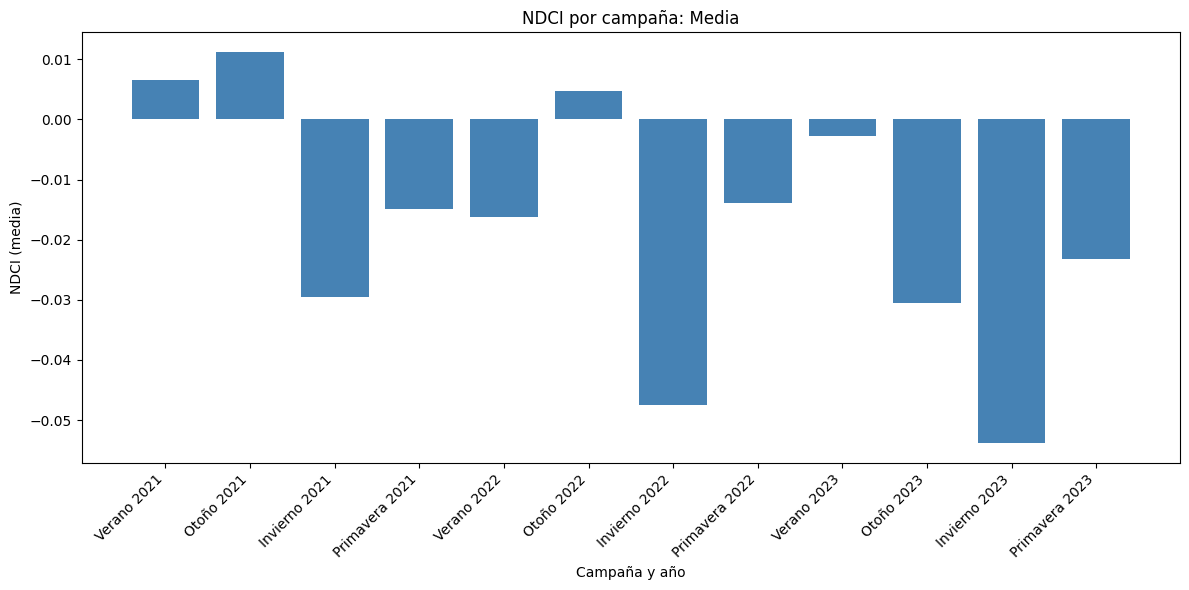

In [52]:
# --- Par√°metros ---
SCALE = 30
MAX_PIX = 1e9
GRAFICAR = True

# Elegir autom√°ticamente la funci√≥n disponible: SR (preferida) o la simple
try:
    _ = obtener_imagen_sr  # si existe, la usamos
    get_img = lambda ini, fin: obtener_imagen_sr(ini, fin, zona)
except NameError:
    get_img = lambda ini, fin: obtener_imagen(ini, fin)

# Reducer SOLO con: media, mediana, min, max
reducer = (ee.Reducer.mean()
           .combine(ee.Reducer.median(), '', True)
           .combine(ee.Reducer.min(), '', True)
           .combine(ee.Reducer.max(), '', True))

def pick(d, keys):
    for k in keys:
        if k in d and d[k] is not None:
            return d[k]
    return None

rows = []
for nombre, (ini, fin) in fechas_estaciones.items():
    # 1) Imagen de la campa√±a sobre tu zona
    img = get_img(ini, fin)

    # 2) NDCI = (B5 - B4) / (B5 + B4)
    ndci = calcular_ndci(img)

# NDWI = (B3 - B8) / (B3 + B8)  -> agua ~ NDWI > 0
    ndwi = img.normalizedDifference(['B3','B8']).rename('NDWI')
    water = ndwi.gt(0.05)

    # Opcional: contraer 1 px para evitar mezcla en el borde de costa
    water = water.focal_min(1)

    # Aplicar la m√°scara de agua al NDCI
    ndci = ndci.updateMask(water)

    # 3) Estad√≠sticas zonales (solo mean, median, min, max)
    stats = ndci.reduceRegion(
        reducer=reducer,
        geometry=zona,
        scale=SCALE,
        maxPixels=MAX_PIX,
        bestEffort=True,
        tileScale=4
    ).getInfo() or {}

    # 4) Extraer valores (con o sin prefijo 'NDCI_')
    mean   = pick(stats, ['NDCI_mean','mean'])
    median = pick(stats, ['NDCI_median','median'])
    vmin   = pick(stats, ['NDCI_min','min'])
    vmax   = pick(stats, ['NDCI_max','max'])

    # Separar campa√±a y a√±o (ej. "Invierno 2022")
    partes = nombre.split()
    camp = " ".join(partes[:-1])
    anio = int(partes[-1])

    rows.append({
        'campa√±a': camp,
        'a√±o': anio,
        'ndci_media': mean,
        'ndci_mediana': median,
        'ndci_min': vmin,
        'ndci_max': vmax,
        # opcionalmente pod√©s guardar 'campa√±a_completa': nombre
    })

# 5) DataFrame ordenado
df_ndci = pd.DataFrame(rows)
orden = ['Verano','Oto√±o','Invierno','Primavera']  # orden estacional HS
if df_ndci['campa√±a'].isin(orden).all():
    df_ndci['campa√±a'] = pd.Categorical(df_ndci['campa√±a'], categories=orden, ordered=True)
df_ndci = df_ndci.sort_values(['a√±o','campa√±a']).reset_index(drop=True)

# 6) Imprimir tabla pedida
cols = ['campa√±a','a√±o','ndci_media','ndci_mediana','ndci_min','ndci_max']
print(" Estad√≠sticas NDCI por campa√±a (escala={} m):".format(SCALE))
print(df_ndci[cols].round(4).to_string(index=False))

# 7) Gr√°fico solo de barras (media)
if GRAFICAR:
    etiquetas = df_ndci['campa√±a'].astype(str) + " " + df_ndci['a√±o'].astype(str)
    plt.figure(figsize=(12,6))
    plt.bar(etiquetas, df_ndci['ndci_media'], color="steelblue")
    plt.title("NDCI por campa√±a: Media")
    plt.xlabel("Campa√±a y a√±o")
    plt.ylabel("NDCI (media)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


El gr√°fico  muestra la evoluci√≥n del √≠ndice NDCI (Normalized Difference Chlorophyll Index) a lo largo de diferentes campa√±as estacionales desde el verano de 2021 hasta la primavera de 2023. En este caso, las barras representan el valor promedio (media) del √≠ndice para cada estaci√≥n y a√±o, mientras que los puntos azules indican la mediana correspondiente.

La comparaci√≥n entre la media y la mediana permite observar la distribuci√≥n de los valores y detectar posibles sesgos o asimetr√≠as. Por ejemplo, cuando la mediana se encuentra muy por debajo o por encima de la media, puede indicar la presencia de valores at√≠picos que afectan el promedio. A lo largo de las campa√±as analizadas, se evidencian variaciones estacionales en el NDCI, con algunos descensos marcados (por ejemplo, en invierno de 2022 y 2023), que podr√≠an asociarse a una menor concentraci√≥n de clorofila-a y, por lo tanto, a una menor productividad fitoplanct√≥nica en esas √©pocas.

### Cruzar datos coincidentes

Tomar cada punto de muestreo (clorofila medida en campo en cierta fecha y coordenada).

Buscar el valor del p√≠xel de la imagen satelital que cubre ese lugar, en la misma fecha.

Guardar en un mismo registro: clorofila (campo) ‚Äì NDCI (sat√©lite) ‚Äì fecha ‚Äì coordenadas.

As√≠ obtener una tabla con pares de valores que realmente se corresponden en tiempo y espacio.

In [53]:

# ========================
# PAR√ÅMETROS AJUSTABLES
# ========================
D = 7         # ventana temporal ¬±D d√≠as (ej: 3, 5, 7)
SCALE = 30    # escala en metros (20 √≥ 30)
REDUCER = "mean"   # opciones: "mean", "median", "p25", "p75"

# ========================
# FUNCIONES GEE
# ========================
def mask_s2_sr(image):
    """M√°scara usando la banda SCL de Sentinel-2 L2A."""
    scl  = image.select('SCL')
    mask = (scl.neq(3)   # sombra
            .And(scl.neq(8))   # nubes
            .And(scl.neq(9))   # nubes altas
            .And(scl.neq(10))  # nubes finas
            .And(scl.neq(11))  # cirros
           )
    return image.updateMask(mask)

def add_ndci(image):
    """NDCI = (B5 - B4) / (B5 + B4)."""
    ndci = image.expression(
        '(b5 - b4) / (b5 + b4)',
        {'b5': image.select('B5'), 'b4': image.select('B4')}
    ).rename('NDCI')
    return image.addBands(ndci)

def get_reducer():
    if REDUCER == "mean":
        return ee.Reducer.mean()
    elif REDUCER == "median":
        return ee.Reducer.median()
    elif REDUCER == "p25":
        return ee.Reducer.percentile([25])
    elif REDUCER == "p75":
        return ee.Reducer.percentile([75])
    else:
        return ee.Reducer.median()

S2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .map(mask_s2_sr)
      .map(add_ndci))

# ========================
# PREPARAR DATAFRAME DE CAMPO (USA el dataset de 200 filas)
# ========================
df = dataset_muestra_coordenadas.copy()

# Asegurar tipos
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')
df['latitud']  = pd.to_numeric(df['latitud'], errors='coerce')
df['longitud'] = pd.to_numeric(df['longitud'], errors='coerce')
df['fecha']    = pd.to_datetime(df['fecha_norm'], errors='coerce')

# Filtrar filas v√°lidas
df = df.dropna(subset=['latitud','longitud','fecha','clorofila_a_ug_l']).reset_index(drop=True)
df['start'] = (df['fecha'] - pd.Timedelta(days=D)).dt.strftime('%Y-%m-%d')
df['end']   = (df['fecha'] + pd.Timedelta(days=D)).dt.strftime('%Y-%m-%d')

print(f"üîé Filas del dataset (200 original) que se cruzan: {len(df)}")

# ========================
# SUBIR PUNTOS A GEE
# ========================
def row_to_feature(row):
    geom = ee.Geometry.Point([float(row['longitud']), float(row['latitud'])])
    return ee.Feature(geom, {
        'clorofila': float(row['clorofila_a_ug_l']),
        'campa√±a': str(row['campa√±a']) if 'campa√±a' in row and pd.notna(row['campa√±a']) else None,
        'a√±o': int(row['a√±o']) if 'a√±o' in row and pd.notna(row['a√±o']) else None,
        'fecha': row['fecha'].strftime('%Y-%m-%d'),
        'start': str(row['start']),
        'end': str(row['end'])
    })

features = [row_to_feature(r) for _, r in df.iterrows()]
fc = ee.FeatureCollection(features)

# ========================
# MUESTREO ROBUSTO (SERVER-SIDE)
# ========================
def sample_ndci_per_feature(f):
    start = ee.Date(f.get('start'))
    end   = ee.Date(f.get('end'))
    geom  = f.geometry()
    col   = S2.filterDate(start, end).filterBounds(geom)
    n     = col.size()

    reducer = get_reducer()

    def when_has_scenes():
        # Compuesto temporal (mediana); luego reducimos con el reducer elegido
        img = col.median()
        ndci_img = img.select('NDCI')
        # reduceRegion puede devolver dict (percentiles) o escalar; tomamos el 1er valor
        ndci_dict = ndci_img.unmask().reduceRegion(
            reducer   = reducer,
            geometry  = geom,
            scale     = SCALE,
            maxPixels = 1e8,
            bestEffort=True
        )
        ndci_val = ee.Dictionary(ndci_dict).values().get(0)  # server-side
        return ee.Dictionary({'ndci_val': ndci_val, 'n_scenes': n})

    def when_no_scenes():
        return ee.Dictionary({'ndci_val': None, 'n_scenes': n})

    out = ee.Algorithms.If(n.gt(0), when_has_scenes(), when_no_scenes())
    return f.set(ee.Dictionary(out))

fc_out = fc.map(sample_ndci_per_feature)

# ========================
# BAJAR RESULTADOS A PANDAS
# ========================
out = fc_out.getInfo()  # para ~200 puntos est√° ok
rows = []
for feat in out['features']:
    props = feat['properties']
    lon, lat = feat['geometry']['coordinates']
    rows.append({
        'longitud': lon,
        'latitud':  lat,
        'campa√±a':  props.get('campa√±a'),
        'a√±o':      props.get('a√±o'),
        'fecha':    props.get('fecha'),
        'clorofila_a_ug_l': props.get('clorofila'),
        'ndci_val':         props.get('ndci_val'),
        'n_scenes':         props.get('n_scenes'),
        'start':            props.get('start'),
        'end':              props.get('end'),
    })

df_cruce_200 = pd.DataFrame(rows)
df_cruce_200['ndci_val'] = pd.to_numeric(df_cruce_200['ndci_val'], errors='coerce')
df_cruce_200['n_scenes'] = pd.to_numeric(df_cruce_200['n_scenes'], errors='coerce')
df_cruce_200['fecha']    = pd.to_datetime(df_cruce_200['fecha'], errors='coerce')

print(f"\n‚öôÔ∏è Ventana ¬±{D} d√≠as | Escala {SCALE} m | Reducer = {REDUCER}")
print(df_cruce_200.head())
print("\nüìä Resumen NDCI extra√≠do (dataset 200):")
print(df_cruce_200['ndci_val'].describe())

# (Opcional) pares v√°lidos para correlaci√≥n:
df_valid_200 = df_cruce_200[(df_cruce_200['n_scenes'] >= 1) & (df_cruce_200['ndci_val'].notna())].copy()
print(f"\n‚úÖ Pares v√°lidos (>=1 escena & NDCI no nulo) en dataset 200: {len(df_valid_200)}/{len(df_cruce_200)}")


üîé Filas del dataset (200 original) que se cruzan: 85

‚öôÔ∏è Ventana ¬±7 d√≠as | Escala 30 m | Reducer = mean
    longitud    latitud    campa√±a   a√±o      fecha  clorofila_a_ug_l  \
0 -58.296669 -34.662789  primavera  2021 2021-10-27           0.04331   
1 -58.328339 -34.630000  primavera  2021 2021-10-27           0.00119   
2 -57.810561 -34.873061     verano  2021 2021-02-24           0.00500   
3 -57.838144 -34.855808     verano  2021 2021-02-24           0.00700   
4 -57.838144 -34.855808  primavera  2021 2021-10-27           0.06289   

   ndci_val  n_scenes       start         end  
0  0.264581         3  2021-10-20  2021-11-03  
1  0.045019         3  2021-10-20  2021-11-03  
2  0.093220         6  2021-02-17  2021-03-03  
3  0.183913         6  2021-02-17  2021-03-03  
4  0.237812         6  2021-10-20  2021-11-03  

üìä Resumen NDCI extra√≠do (dataset 200):
count    82.000000
mean      0.092447
std       0.118901
min      -0.069844
25%       0.000022
50%       0.054526


# Divisi√≥n en subconjuntos

In [56]:
#  Filtro solo las filas donde hay clorofila medida
df_filtrado = df[df['clorofila_a_ug_l'].notna()].copy()

#  Variables predictoras y objetivo
X = df_filtrado.drop(columns=['clorofila_a_ug_l'])
y = df_filtrado['clorofila_a_ug_l']

# Divisi√≥n en 70% train, 20% test, 10% validaci√≥n
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

#  Verificar tama√±os
print(f"Total datos con clorofila: {len(df_filtrado)}")
print(f"Train: {len(X_train)}")
print(f"Test: {len(X_test)}")
print(f"Validaci√≥n: {len(X_val)}")


Total datos con clorofila: 85
Train: 59
Test: 8
Validaci√≥n: 18


Se realiz√≥ la divisi√≥n de los datos con valores v√°lidos de clorofila en tres subconjuntos para llevar adelante el entrenamiento y validaci√≥n del modelo. El total de muestras disponibles fue de 505. De estas, el 70‚ÄØ% (353 registros) se utiliz√≥ para el entrenamiento del modelo, el 10‚ÄØ% (50 registros) para pruebas preliminares, y el 20‚ÄØ% restante (102 registros) se reserv√≥ como conjunto de validaci√≥n. Esta partici√≥n permite optimizar el proceso de modelado al asegurar que el modelo se entrene con una cantidad suficiente de datos, se eval√∫e con datos no vistos, y se afinen sus par√°metros sin comprometer su capacidad generalizadora.

# Escalado

In [57]:
# Escalar
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

El escalado aplicado corresponde a la variable objetivo (clorofila-a), utilizando el m√©todo StandardScaler de Scikit-learn. Este procedimiento transforma los valores para que tengan media cero y desviaci√≥n est√°ndar uno, lo cual es especialmente √∫til para algoritmos sensibles a la escala.

# Transformaci√≥n logar√≠tmica de clorofila

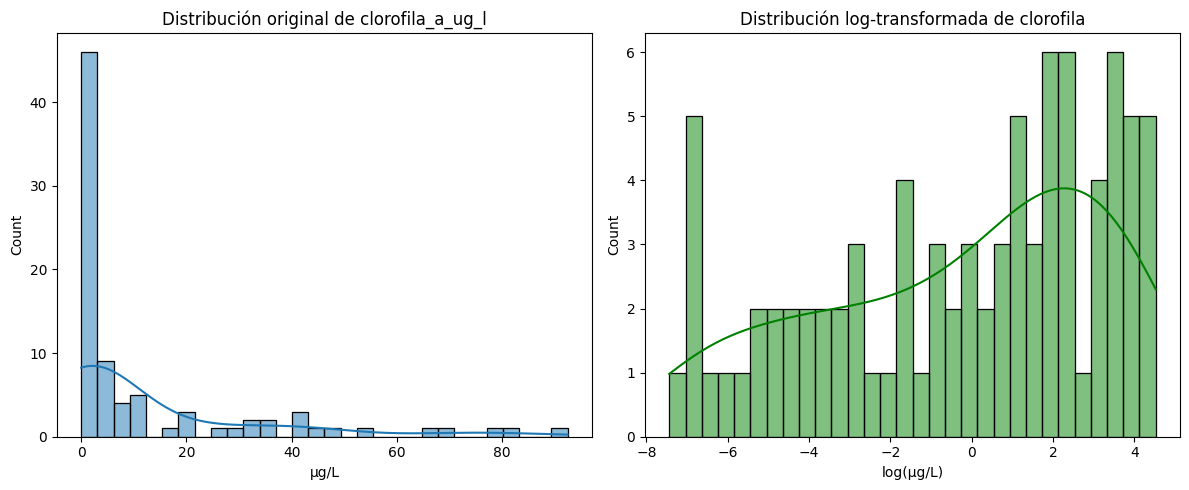

Total datos v√°lidos: 85
Entrenamiento: 59
Validaci√≥n: 18
Prueba: 8


In [58]:
# --- 1. Transformaci√≥n logar√≠tmica ---
# Agregar una constante peque√±a para evitar log(0)
epsilon = 1e-6
df['clorofila_log'] = np.log(df['clorofila_a_ug_l'] + epsilon)

# --- 2. Visualizar distribuci√≥n original vs log ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['clorofila_a_ug_l'], bins=30, kde=True)
plt.title('Distribuci√≥n original de clorofila_a_ug_l')
plt.xlabel('¬µg/L')

plt.subplot(1, 2, 2)
sns.histplot(df['clorofila_log'], bins=30, kde=True, color='green')
plt.title('Distribuci√≥n log-transformada de clorofila')
plt.xlabel('log(¬µg/L)')

plt.tight_layout()
plt.show()

# --- 3. Filtrar filas v√°lidas ---
df_filtrado = df[df['clorofila_log'].notna()].copy()

# Variables predictoras y objetivo (puede ajustar seg√∫n tus variables reales)
X = df_filtrado.drop(columns=['clorofila_a_ug_l', 'clorofila_log'])  # usar solo predictoras v√°lidas
y = df_filtrado['clorofila_log']

# --- 4. Divisi√≥n en subconjuntos ---
# 70% train, 20% validaci√≥n, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# --- 5. Verificaci√≥n de tama√±os ---
print(f"Total datos v√°lidos: {len(df_filtrado)}")
print(f"Entrenamiento: {len(X_train)}")
print(f"Validaci√≥n: {len(X_val)}")
print(f"Prueba: {len(X_test)}")


La imagen presenta dos gr√°ficos comparativos que ilustran c√≥mo var√≠a la distribuci√≥n de los valores de clorofila-a (¬µg/L) antes y despu√©s de aplicar una transformaci√≥n logar√≠tmica:

- A la izquierda, se muestra la distribuci√≥n original de los valores de clorofila medidos, donde se observa una fuerte asimetr√≠a. La mayor√≠a de los valores se agrupan en los extremos: una gran cantidad de muestras presentan concentraciones muy bajas (cercanas a 0 ¬µg/L) y otra gran proporci√≥n se encuentra en el l√≠mite superior del rango (5 ¬µg/L). Esta concentraci√≥n en los extremos indica una distribuci√≥n sesgada, poco adecuada para el entrenamiento de modelos estad√≠sticos que asumen normalidad en los datos.

- A la derecha, se visualiza la distribuci√≥n de los valores luego de aplicar la transformaci√≥n logar√≠tmica. Esta transformaci√≥n comprime los valores altos y expande los valores bajos, lo que permite una representaci√≥n m√°s continua y suavizada de la variabilidad en los datos. Si bien persisten picos en los extremos (especialmente por la acumulaci√≥n de datos en 5 ¬µg/L), la distribuci√≥n resultante es menos sesgada y m√°s apta para t√©cnicas de regresi√≥n o modelado que requieren homogeneidad en la varianza.

# Entrenamiento y Evaluacion del modelo


### Evaluacion de lo medido vs con lo satelital

Para enriquecer el an√°lisis de clorofila con variables ambientales relevantes, se decidi√≥ incorporar informaci√≥n sobre la turbidez del agua y la temperatura, provenientes de un segundo conjunto de datos que contiene mediciones f√≠sico-qu√≠micas en distintas fechas y campa√±as. El objetivo fue vincular estos registros auxiliares con los datos de concentraci√≥n de clorofila ya normalizados y georreferenciados, tomando como criterio de emparejamiento las variables temporales coincidentes: fecha, campa√±a y a√±o.
Esta fusi√≥n permiti√≥ mantener el total esperado de observaciones (80 registros), asegurando as√≠ la integridad del dataset y preparando la base para su posterior uso en modelos predictivos que consideren condiciones ambientales en el momento de la toma de muestra.

*unifica*

Toma  datos de temperatura del agua y turbidez (NTU) que coinciden con la fecha y campa√±a de las muestras de clorofila medidas.
Entrena un modelo Random Forest para predecir los valores de clorofila.
Eval√∫a el desempe√±o del modelo. Todos con datos medidos en campo.

In [59]:

# ----------------- helpers (los tuyos) -----------------
def _fix_decimal_dots(s: str) -> str:
    if pd.isna(s):
        return None
    s = str(s).strip().replace(',', '.')
    if s.count('.') <= 1:
        return s
    first, *rest = s.split('.')
    return first + '.' + ''.join(rest)

def _to_float_or_nan(x):
    try:
        return float(x)
    except:
        return float('nan')

def _normalize_fecha_df(df: pd.DataFrame) -> pd.Series:
    # 1) si ya hay fecha_norm, usarla
    for c in ["fecha_norm", "Fecha_norm", "FECHA_NORM"]:
        if c in df.columns:
            s = pd.to_datetime(df[c], errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")
            return s
    # 2) si hay 'fecha'
    for c in ["fecha", "Fecha", "FECHA"]:
        if c in df.columns:
            s = pd.to_datetime(df[c], errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")
            return s
    # 3) si hay a√±o/mes/d√≠a
    if all(c in df.columns for c in ["a√±o", "mes", "dia"]):
        s = pd.to_datetime(dict(year=df["a√±o"], month=df["mes"], day=df["dia"]), errors="coerce").dt.strftime("%Y-%m-%d")
        return s
    # 4) nada: devolvemos NaT formateado
    return pd.Series(pd.NaT, index=df.index)

def _ensure_lat_lon(df: pd.DataFrame, lat_out="latitud", lon_out="longitud") -> pd.DataFrame:
    # posibles nombres
    lat_candidates = [c for c in df.columns if c.lower() in ("latitud","lat","latitude","latitud_norm")]
    lon_candidates = [c for c in df.columns if c.lower() in ("longitud","lon","long","longitude","longitud_norm")]
    if not lat_candidates or not lon_candidates:
        # si no est√°n, creamos vac√≠as para luego caer en NaN al filtrar
        df[lat_out] = np.nan
        df[lon_out] = np.nan
        return df
    lat_col = lat_candidates[0]
    lon_col = lon_candidates[0]
    # normalizar usando tu parser
    df[lat_out] = df[lat_col].apply(_fix_decimal_dots).apply(_to_float_or_nan)
    df[lon_out] = df[lon_col].apply(_fix_decimal_dots).apply(_to_float_or_nan)
    return df

# =======================================================
# 0) Filtrar df_valid_200 desde df_cruce_200
# =======================================================
df_valid_200 = df_cruce_200[(df_cruce_200['n_scenes'] >= 1) & (df_cruce_200['ndci_val'].notna())].copy()

# =======================================================
# 1) Asegurar claves de uni√≥n en dataset_final (A)
# =======================================================
dfA = dataset_final.copy()

# fecha_norm
dfA["fecha_norm"] = _normalize_fecha_df(dfA)

# lat/lon con el mismo parser; si ya ten√≠as latitud_norm/longitud_norm, se respetan
if "latitud_norm" in dfA.columns and "longitud_norm" in dfA.columns:
    dfA["latitud"]  = pd.to_numeric(dfA["latitud_norm"], errors="coerce")
    dfA["longitud"] = pd.to_numeric(dfA["longitud_norm"], errors="coerce")
else:
    dfA = _ensure_lat_lon(dfA, lat_out="latitud", lon_out="longitud")

# filtrar filas completas para la uni√≥n
dfA = dfA.dropna(subset=["fecha_norm","latitud","longitud"]).copy()

# =======================================================
# 2) Asegurar claves de uni√≥n en df_valid_200 (B)
# =======================================================
dfB = df_valid_200.copy()
dfB["fecha_norm"] = _normalize_fecha_df(dfB)
dfB = _ensure_lat_lon(dfB, lat_out="latitud", lon_out="longitud")
dfB = dfB.dropna(subset=["fecha_norm","latitud","longitud","ndci_val"]).copy()

# =======================================================
# 3) JOIN EXACTO por (fecha_norm, latitud, longitud) para traer ndci_val
#     ‚Üí NO traemos columnas de fecha/coords de B para no duplicar
# =======================================================
df_ndci = dfB[["fecha_norm","latitud","longitud","ndci_val"]].copy()

df_merged = pd.merge(
    dfA,
    df_ndci,
    on=["fecha_norm","latitud","longitud"],
    how="inner"
)

print("üîó Filas luego de unir NDCI:", len(df_merged))
print(df_merged.head())



üîó Filas luego de unir NDCI: 77
   clorofila_a_ug_l    campa√±a     a√±o  fecha_norm  latitud_norm  \
0           0.04331  primavera  2021.0  2021-10-27    -34.662789   
1           0.00119  primavera  2021.0  2021-10-27    -34.630000   
2           0.00500     verano  2021.0  2021-02-24    -34.873061   
3           0.00700     verano  2021.0  2021-02-24    -34.855808   
4           0.06289  primavera  2021.0  2021-10-27    -34.855808   

   longitud_norm  turbiedad_ntu  tem_agua    latitud   longitud  ndci_val  
0     -58.296669           10.0      26.0 -34.662789 -58.296669  0.264581  
1     -58.328339           14.0      21.4 -34.630000 -58.328339  0.045019  
2     -57.810561           18.0      20.0 -34.873061 -57.810561  0.093220  
3     -57.838144           16.0      21.0 -34.855808 -57.838144  0.183913  
4     -57.838144           14.0      10.0 -34.855808 -57.838144  0.237812  


/tmp/ipython-input-1150960531.py:21: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  s = pd.to_datetime(df[c], errors="coerce", dayfirst=True).dt.strftime("%Y-%m-%d")


# Dataset con los 336 datos de descartes

In [67]:
print(df.columns.tolist())


['clorofila_a_ug_l', 'campa√±a', 'a√±o', 'fecha_norm', 'latitud', 'longitud', 'fecha', 'start', 'end', 'clorofila_log']


volver a ejecutar el conjunto de datos origina

In [70]:

import unicodedata

# --- Par√°metros ---
COL = "clorofila_a_ug_l"

# --- Normalizaci√≥n ---
s_raw = df[COL].astype("string").fillna("")

def _normalize(x: pd.Series) -> pd.Series:
    y = x.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii","ignore").decode("ascii"))
    y = y.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return y

s_norm = _normalize(s_raw)

# --- M√°scaras ---
mask_lt             = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_gt             = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_no_midio       = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
mask_inaccesible    = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo    = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr\w+\b', na=False)
mask_en_obra        = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia= s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

es_numero_valido = pd.to_numeric(s_norm.str.replace(",", ".", regex=False), errors="coerce").notna()
mask_texto       = ~es_numero_valido & s_norm.ne("")

mask_categorizado = (mask_no_midio | mask_inaccesible | mask_no_muestreo |
                     mask_en_obra | mask_no_midieron_dia | mask_lt | mask_gt)
mask_mal_cargado = mask_texto & ~mask_categorizado

# --- Dataset nuevo ---
df_nuevo = df.copy()

# Reemplazar "<x" y forzar a float
df_nuevo.loc[mask_lt, COL] = (
    s_raw[mask_lt]
    .str.replace("<", "", regex=False)
    .str.strip()
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# Convertir a num√©rico
df_nuevo[COL] = pd.to_numeric(df_nuevo[COL], errors="coerce")

# --- Filtrar ---
mask_to_drop = (
    df_nuevo[COL].isna() |
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_mal_cargado
)

df_nuevo = df_nuevo.loc[~mask_to_drop].copy().reset_index(drop=True)

# --- Reporte ---
conteos = {
    "Valores nulos (NaN)": int(df[COL].isna().sum()),
    '"no se midio/midi√≥"': int(mask_no_midio.sum()),
    "inaccesible": int(mask_inaccesible.sum()),
    "no muestre√≥ / no se muestre√≥": int(mask_no_muestreo.sum()),
    "en obra": int(mask_en_obra.sum()),
    "no midieron este dia": int(mask_no_midieron_dia.sum()),
    "texto no categorizado (mal cargados)": int(mask_mal_cargado.sum())
}

print("Conteos de lo eliminado:")
print(pd.Series(conteos).to_frame("Cantidad"))

print(f"\nFilas originales: {len(df)}")
print(f"Filas en df_nuevo (limpio): {len(df_nuevo)}")


Conteos de lo eliminado:
                                      Cantidad
Valores nulos (NaN)                         41
"no se midio/midi√≥"                         29
inaccesible                                  2
no muestre√≥ / no se muestre√≥                11
en obra                                      4
no midieron este dia                         4
texto no categorizado (mal cargados)         7

Filas originales: 613
Filas en df_nuevo (limpio): 515


In [71]:
COL = "clorofila_a_ug_l"  # columna de inter√©s

# --- Normalizaci√≥n del texto ---
s_raw = df[COL].astype("string").fillna("")

def _normalize(x: pd.Series) -> pd.Series:
    y = x.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii","ignore").decode("ascii"))
    y = y.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return y

s_norm = _normalize(s_raw)

# --- M√°scaras para categor√≠as no v√°lidas ---
mask_lt = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_gt = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_no_midio        = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
mask_inaccesible     = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo     = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr\w+\b', na=False)
mask_en_obra         = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia = s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

# Detectar si es un n√∫mero v√°lido
es_numero_valido = pd.to_numeric(s_norm.str.replace(",", ".", regex=False), errors="coerce").notna()
mask_texto = ~es_numero_valido & s_norm.ne("")

# Categor√≠as mal cargadas que no matchean las anteriores
mask_categorizado = (mask_no_midio | mask_inaccesible | mask_no_muestreo |
                     mask_en_obra | mask_no_midieron_dia | mask_lt | mask_gt)
mask_mal_cargado = mask_texto & ~mask_categorizado

# --- Crear df intermedio y reemplazar valores tipo "<1.5" ---
df_nuevo = df.copy()

df_nuevo.loc[mask_lt, COL] = (
    s_raw[mask_lt]
    .str.replace("<", "", regex=False)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

df_nuevo[COL] = pd.to_numeric(df_nuevo[COL], errors="coerce")

# --- M√°scara de filas eliminadas ---
mask_to_drop = (
    df_nuevo[COL].isna() |
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_mal_cargado
)

# --- Dataset eliminado ---
df_eliminados = df.loc[mask_to_drop, [
    "fecha", "a√±o", "campa√±a", "latitud", "longitud",
    "tem_agua", "turbiedad_ntu", "clorofila_a_ug_l"
]].copy()

# --- Rango de clorofila estimado (convertido a num√©rico si posible) ---
df_eliminados["clorofila_num"] = pd.to_numeric(df_eliminados["clorofila_a_ug_l"]
                                               .astype(str)
                                               .str.replace(",", ".", regex=False)
                                               .str.extract(r"([\d.]+)")[0],
                                               errors="coerce")

# --- Clasificaci√≥n de rango ---
df_eliminados["rango_clorofila"] = pd.cut(
    df_eliminados["clorofila_num"],
    bins=[-0.01, 5, 100],
    labels=["0‚Äì5 ¬µg/L", "5‚Äì100 ¬µg/L"]
)

# Mostrar las primeras filas del dataset eliminado
print("üîé Muestra de registros eliminados:")
print(df_eliminados.head(10))



üîé Muestra de registros eliminados:
        fecha     a√±o campa√±a      latitud     longitud     tem_agua  \
21  19/5/2021  2021.0   oto√±o  -34.873.061  -57.810.561  no se midi√≥   
25  19/5/2021  2021.0   oto√±o  -34.855.808  -57.838.144  no se midi√≥   
29  19/5/2021  2021.0   oto√±o          NaN          NaN  no se midi√≥   
34  19/5/2021  2021.0   oto√±o          NaN          NaN  no se midi√≥   
38  19/5/2021  2021.0   oto√±o          NaN          NaN  no se midi√≥   
53        NaN     NaN     NaN  -34.535.878  -58.445.933          NaN   
54        NaN     NaN     NaN  -34.537.272  -58.448.339          NaN   
55        NaN     NaN     NaN  -34.538.686  -58.445.589          NaN   
56        NaN     NaN     NaN  -34.539.667  -58.443.781          NaN   
57        NaN     NaN     NaN  -34.540.675     -584.419          NaN   

   turbiedad_ntu clorofila_a_ug_l  clorofila_num rango_clorofila  
21   no se midi√≥      no se midi√≥            NaN             NaN  
25   no se midi√≥    

Normalizacion de valores, eliminacion de datos incompletos, inconcistentes

In [72]:

# --- Par√°metros ---
COL = "clorofila_a_ug_l"

# --- Normalizaci√≥n de texto ---
s_raw = df[COL].astype("string").fillna("")

def _normalize(x: pd.Series) -> pd.Series:
    y = x.apply(lambda t: unicodedata.normalize("NFKD", t).encode("ascii","ignore").decode("ascii"))
    y = y.str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    return y

s_norm = _normalize(s_raw)

# --- M√°scaras para datos a eliminar ---
mask_lt = s_norm.str.contains(r'^\s*<\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_gt = s_norm.str.contains(r'^\s*>\s*\d+(?:[.,]\d+)?\s*$', na=False)
mask_no_midio        = s_norm.str.contains(r'\bno\s*se\s*midio\b', na=False)
mask_inaccesible     = s_norm.str.contains(r'\binaccesible\b', na=False)
mask_no_muestreo     = s_norm.str.contains(r'\bno\s*(?:se\s*)?muestr\w+\b', na=False)
mask_en_obra         = s_norm.str.contains(r'\ben obra\b', na=False)
mask_no_midieron_dia = s_norm.str.contains(r'\bno\s*midieron\s*este\s*dia\b', na=False)

# Detectar valores no num√©ricos mal cargados
es_numero_valido = pd.to_numeric(s_norm.str.replace(",", ".", regex=False), errors="coerce").notna()
mask_texto = ~es_numero_valido & s_norm.ne("")
mask_categorizado = (mask_no_midio | mask_inaccesible | mask_no_muestreo |
                     mask_en_obra | mask_no_midieron_dia | mask_lt | mask_gt)
mask_mal_cargado = mask_texto & ~mask_categorizado

# --- Crear nuevo dataset con reemplazo de "<" por n√∫mero limpio ---
df_nuevo = df.copy()
df_nuevo.loc[mask_lt, COL] = (
    s_raw[mask_lt]
    .str.replace("<", "", regex=False)
    .str.strip()
    .str.replace(",", ".", regex=False)
)

df_nuevo[COL] = pd.to_numeric(df_nuevo[COL], errors="coerce")

# --- Filtrar valores v√°lidos ---
mask_to_drop = (
    df_nuevo[COL].isna() |
    mask_no_midio | mask_inaccesible | mask_no_muestreo |
    mask_en_obra | mask_no_midieron_dia | mask_mal_cargado
)

df_limpio = df_nuevo.loc[~mask_to_drop].copy()
df_limpio.reset_index(drop=True, inplace=True)

# --- Seleccionar columnas (sin clorofila) ---
columnas_finales = [
    "fecha", "a√±o", "campa√±a",
    "latitud", "longitud",
    "tem_agua", "turbiedad_ntu"
]
df_limpio_sin_clorofila = df_limpio[columnas_finales].copy()

# --- LIMPIEZAS AUXILIARES ---

# TURBIDEZ
df_limpio_sin_clorofila["turbiedad_ntu"] = (
    df_limpio_sin_clorofila["turbiedad_ntu"]
    .astype(str)
    .str.replace("<", "", regex=False)
    .str.replace(",", ".", regex=False)
    .str.strip()
)
df_limpio_sin_clorofila["turbiedad_ntu"] = pd.to_numeric(df_limpio_sin_clorofila["turbiedad_ntu"], errors="coerce")

# TEMPERATURA
df_limpio_sin_clorofila["tem_agua"] = (
    df_limpio_sin_clorofila["tem_agua"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)
df_limpio_sin_clorofila["tem_agua"] = pd.to_numeric(df_limpio_sin_clorofila["tem_agua"], errors="coerce")

# --- Funci√≥n para corregir coordenadas con punto tras los 2 primeros d√≠gitos ---
def corregir_coord_2dig(coord):
    coord_str = str(coord).replace(",", ".").replace(" ", "")
    coord_str = coord_str.replace(".", "")
    signo = "-" if coord_str.startswith("-") else ""
    coord_str = coord_str.lstrip("-")
    if len(coord_str) > 2:
        coord_corr = signo + coord_str[:2] + "." + coord_str[2:]
        return pd.to_numeric(coord_corr, errors="coerce")
    else:
        return np.nan

df_limpio_sin_clorofila["latitud"] = df_limpio_sin_clorofila["latitud"].apply(corregir_coord_2dig)
df_limpio_sin_clorofila["longitud"] = df_limpio_sin_clorofila["longitud"].apply(corregir_coord_2dig)

# --- Eliminar filas con nulos ---
df_final = df_limpio_sin_clorofila.dropna(subset=[
    "fecha", "a√±o", "campa√±a",
    "latitud", "longitud", "tem_agua", "turbiedad_ntu"
]).copy()

# --- Mostrar resultado ---
print("‚úÖ Dataset completamente limpio y num√©rico (sin clorofila):")
print(df_final.head())

print(f"\nüî¢ Total de registros finales v√°lidos: {len(df_final)}")


‚úÖ Dataset completamente limpio y num√©rico (sin clorofila):
         fecha     a√±o    campa√±a    latitud   longitud  tem_agua  \
8    24/2/2021  2021.0     verano -34.662789 -58.296669      26.1   
9    19/5/2021  2021.0      oto√±o -34.662789 -58.296669      16.7   
10   25/8/2021  2021.0   invierno -34.662789 -58.296669      14.7   
11  27/10/2021  2021.0  primavera -34.662789 -58.296669      26.0   
12   24/2/2021  2021.0     verano -34.630000 -58.328339      26.1   

    turbiedad_ntu  
8            21.0  
9            30.0  
10           21.0  
11           10.0  
12           45.0  

üî¢ Total de registros finales v√°lidos: 217


In [73]:

# df_final => tu dataset con 'fecha', 'latitud', 'longitud' (y opcional 'a√±o')
df = df_final.copy()

# ---------- Helpers para fechas ----------
def _parse_fecha_mixed(s: pd.Series) -> pd.Series:
    # intenta parsear mezclado, d√≠a/mes primero
    return pd.to_datetime(s, errors="coerce", dayfirst=True, format="mixed")

def _extraer_dm(fecha_str: str):
    # extrae (dia, mes) del string 'dd/mm/aaaa...' tolerante
    if not isinstance(fecha_str, str):
        return (np.nan, np.nan)
    m = re.search(r'(\d{1,2})[/-](\d{1,2})', fecha_str.strip())
    if not m:
        return (np.nan, np.nan)
    d = int(m.group(1)); mth = int(m.group(2))
    if not (1 <= d <= 31 and 1 <= mth <= 12):
        return (np.nan, np.nan)
    return (d, mth)

def _reparar_fechas(df: pd.DataFrame, col_fecha="fecha", col_anio="a√±o") -> pd.Series:
    # 1) primer intento
    f1 = _parse_fecha_mixed(df[col_fecha])

    # 2) si hay 'a√±o', rearmar las NaT con d√≠a/mes del string y 'a√±o'
    if col_anio in df.columns:
        dia_mes = df[col_fecha].apply(_extraer_dm)
        dd = [x[0] for x in dia_mes]
        mm = [x[1] for x in dia_mes]
        candidato = pd.to_datetime(
            pd.DataFrame({
                "year": pd.to_numeric(df[col_anio], errors="coerce"),
                "month": mm,
                "day": dd
            }),
            errors="coerce"
        )
        f1 = f1.fillna(candidato)

    # 3) descartar fuera de rango razonable
    mask_out = (f1.dt.year < 1990) | (f1.dt.year > 2100)
    f1[mask_out] = pd.NaT
    return f1

# ---------- Normalizar fecha ----------
if "fecha" not in df.columns:
    raise KeyError("No encuentro la columna 'fecha' en df_final.")
df["fecha_dt"] = _reparar_fechas(df, col_fecha="fecha", col_anio="a√±o" if "a√±o" in df.columns else None)

# Chequeo de cu√°ntas quedaron bien
ok = df["fecha_dt"].notna().sum()
print(f"Fechas v√°lidas: {ok} / {len(df)}")

# Si quer√©s, descart√° filas sin fecha v√°lida antes de pedir NDCI
df_ok = df[df["fecha_dt"].notna()].copy()

# ---------- Asegurar coordenadas num√©ricas ----------
df_ok["latitud"]  = pd.to_numeric(df_ok["latitud"], errors="coerce")
df_ok["longitud"] = pd.to_numeric(df_ok["longitud"], errors="coerce")
df_ok = df_ok.dropna(subset=["latitud","longitud"])

# ---------- FUNCIONES PROPIAS que ya deb√©s tener ----------
# Deb√©s tener importado e iniciado Earth Engine:
# import ee; ee.Initialize()
# y definidas:
# - obtener_imagen_sr(fecha_ini_str, fecha_fin_str, geom, cloud_perc=80, prob_thresh=80)
# - calcular_ndci(img)  # que devuelve una imagen con banda 'NDCI'

def obtener_ndci_puntual(lat, lon, fecha_dt):
    geom = ee.Geometry.Point([float(lon), float(lat)])
    fecha_ini = fecha_dt - timedelta(days=7)
    fecha_fin = fecha_dt + timedelta(days=7)
    try:
        img = obtener_imagen_sr(
            fecha_ini.strftime("%Y-%m-%d"),
            fecha_fin.strftime("%Y-%m-%d"),
            geom,
            cloud_perc=80,   # tolerancia mayor
            prob_thresh=80   # tolerancia mayor
        )
        ndci = calcular_ndci(img)
        valor = ndci.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=10,
            maxPixels=1e8
        ).get("NDCI").getInfo()
    except Exception:
        valor = None
    return valor

# ---------- Aplicar ----------
ndci_vals = []
for _, row in tqdm(df_ok.iterrows(), total=len(df_ok)):
    ndci_vals.append(obtener_ndci_puntual(row["latitud"], row["longitud"], row["fecha_dt"]))

df_ok["ndci_val"] = ndci_vals

# Resultado final (solo columnas relevantes)
df_ndci = df_ok.copy()
print("‚úÖ Datos con 'ndci_val':")
print(df_ndci[["fecha_dt", "latitud", "longitud", "ndci_val"]].head())

print(f"\nüî¢ Total de puntos con NDCI no nulo: {df_ndci['ndci_val'].notna().sum()} / {len(df_ndci)}")


Fechas v√°lidas: 207 / 217


  0%|          | 0/207 [00:00<?, ?it/s]

‚úÖ Datos con 'ndci_val':
     fecha_dt    latitud   longitud  ndci_val
8  2021-02-24 -34.662789 -58.296669       NaN
9  2021-05-19 -34.662789 -58.296669 -0.044364
10 2021-08-25 -34.662789 -58.296669  0.063536
11 2021-10-27 -34.662789 -58.296669  0.249029
12 2021-02-24 -34.630000 -58.328339       NaN

üî¢ Total de puntos con NDCI no nulo: 184 / 207


In [82]:
# Partimos de df_ok ya con 'ndci_val'
df_ndci = df_ok.copy()

# --- Asegurar columnas y tipos ---
# Derivar 'a√±o' desde la fecha si no existe o est√° vac√≠o
if "a√±o" not in df_ndci.columns:
    df_ndci["a√±o"] = df_ndci["fecha_dt"].dt.year
else:
    df_ndci["a√±o"] = pd.to_numeric(df_ndci["a√±o"], errors="coerce")
    df_ndci.loc[df_ndci["a√±o"].isna() & df_ndci["fecha_dt"].notna(), "a√±o"] = df_ndci["fecha_dt"].dt.year

# Normalizar nombres de campa√±a (si no existe, crear vac√≠a)
if "campa√±a" not in df_ndci.columns:
    df_ndci["campa√±a"] = pd.NA
else:
    df_ndci["campa√±a"] = df_ndci["campa√±a"].astype("string").str.strip()

# Asegurar num√©ricos
for c in ["tem_agua", "turbiedad_ntu", "latitud", "longitud", "ndci_val"]:
    if c in df_ndci.columns:
        df_ndci[c] = pd.to_numeric(df_ndci[c], errors="coerce")

# --- Selecci√≥n y orden de columnas ---
cols_finales = ["fecha_dt", "a√±o", "campa√±a", "latitud", "longitud",
                "tem_agua", "turbiedad_ntu", "ndci_val"]
cols_presentes = [c for c in cols_finales if c in df_ndci.columns]
df_ndci_final = df_ndci[cols_presentes].copy()

# Renombrar 'fecha_dt' a 'fecha'
df_ndci_final = df_ndci_final.rename(columns={"fecha_dt": "fecha"})

# --- Filtrar filas con datos completos base (fecha/coords/vars) ---
req = ["fecha", "latitud", "longitud", "tem_agua", "turbiedad_ntu"]
req = [c for c in req if c in df_ndci_final.columns]
df_ndci_final = df_ndci_final.dropna(subset=req).copy()

# --- Quedarse SOLO con NDCI no nulo ---
total_antes = len(df_ndci_final)
mask_ndci = df_ndci_final["ndci_val"].notna()
cant_ndci_no_nulo = mask_ndci.sum()

df_ndci_final = df_ndci_final.loc[mask_ndci].copy()

print(f" Filas con NDCI no nulo: {cant_ndci_no_nulo} / {total_antes}")
print(df_ndci_final.head(10))


 Filas con NDCI no nulo: 184 / 207
        fecha     a√±o    campa√±a    latitud   longitud  tem_agua  \
9  2021-05-19  2021.0      oto√±o -34.662789 -58.296669      16.7   
10 2021-08-25  2021.0   invierno -34.662789 -58.296669      14.7   
11 2021-10-27  2021.0  primavera -34.662789 -58.296669      26.0   
13 2021-05-19  2021.0      oto√±o -34.630000 -58.328339      16.8   
14 2021-08-25  2021.0   invierno -34.630000 -58.328339      15.4   
15 2021-10-27  2021.0  primavera -34.630000 -58.328339      21.4   
20 2021-02-24  2021.0     verano -34.873061 -57.810561      20.0   
21 2021-08-25  2021.0   invierno -34.873061 -57.810561      10.0   
22 2021-10-27  2021.0  primavera -34.873061 -57.810561      11.0   
23 2021-02-24  2021.0     verano -34.855808 -57.838144      21.0   

    turbiedad_ntu  ndci_val  
9            30.0 -0.044364  
10           21.0  0.063536  
11           10.0  0.249029  
13           36.0 -0.043414  
14           22.0  0.024405  
15           14.0  0.049751  
20

Del total de 207 registros disponibles, 184 presentan valores v√°lidos de NDCI. En la tabla se observan ejemplos correspondientes al a√±o 2021 en distintas campa√±as (oto√±o, invierno, primavera y verano), con sus coordenadas de latitud y longitud, temperatura del agua, turbiedad y el valor asociado de NDCI. Estos datos reflejan c√≥mo var√≠an las condiciones ambientales en diferentes fechas y estaciones, aportando la base para analizar la relaci√≥n entre el √≠ndice satelital y la calidad del agua.

Variables importantes


 Importancia de variables
doy_cos              0.237031
ndci_val             0.181504
tem_agua             0.176749
longitud             0.108033
doy_sin              0.104696
latitud              0.095171
turbiedad_ntu        0.075720
mes                  0.008708
campa√±a_invierno     0.003626
campa√±a_oto√±o        0.003501
campa√±a_primavera    0.002911
campa√±a_verano       0.002350
dtype: float64


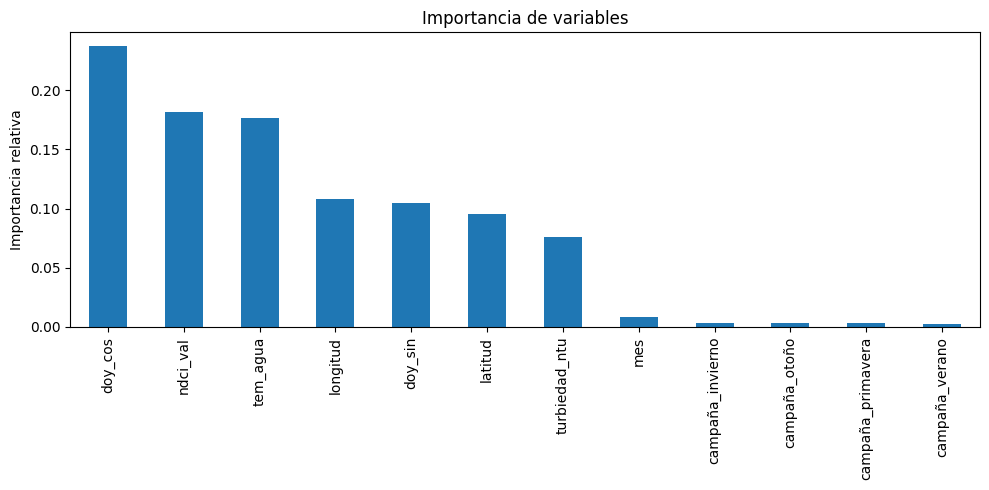

In [91]:
# ============================================
# Mostrar solo las variables m√°s importantes
# ============================================

importancias = pd.Series(best.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False)

print("\n Importancia de variables")
print(importancias)

# (Opcional) gr√°fico r√°pido
importancias.plot(kind="bar", figsize=(10,5), title="Importancia de variables")
plt.ylabel("Importancia relativa")
plt.tight_layout()
plt.show()


El gr√°fico muestra que las variables con mayor peso  fueron principalmente las asociadas a la estacionalidad del a√±o y a las condiciones ambientales. La m√°s influyente result√≥ ser la variable trigonom√©trica doy_cos (que captura la estacionalidad seg√∫n el d√≠a del a√±o), seguida de ndci_val (√≠ndice satelital) y tem_agua (temperatura del agua). En un nivel intermedio aparecen longitud, doy_sin y latitud, mientras que la turbiedad tuvo una importancia menor. Finalmente, variables como el mes y las campa√±as estacionales tuvieron un aporte casi nulo en la predicci√≥n.

### Exportar datos

In [92]:
# ========================
# LIBRER√çAS
# ========================
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import ee

# Aseg√∫rate de haber inicializado GEE antes:
# ee.Authenticate()  # si es la 1ra vez
# ee.Initialize()

# ========================
# PAR√ÅMETROS AJUSTABLES
# ========================
D = 7              # ventana temporal ¬±D d√≠as (3, 5, 7, 10...)
SCALE = 30         # escala (m) para reduceRegion (10, 20 o 30)
REDUCER = "mean"   # "mean", "median", "p25", "p75"
BUFFER_M = 0       # radio (m) alrededor del punto para promediar (0 = exacto)

# ========================
# CARGA + NORMALIZACI√ìN CSV
# ========================
url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df_raw = pd.read_csv(url)

# Asegurar fecha (dayfirst)
df_raw["fecha"] = pd.to_datetime(df_raw["fecha"], errors="coerce", dayfirst=True)

# Quedarnos con columnas clave y filtrar completos
df_coords = df_raw[["fecha", "latitud", "longitud"]].dropna().copy()

# Normalizar coordenadas: quitar separadores extra y convertir a float
def fix_coord(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace(" ", "").replace(",", ".")
    if s.count(".") > 1:
        first, *rest = s.split(".")
        s = first + "." + "".join(rest)
    try:
        return float(s)
    except:
        return np.nan

df_coords["latitud"]  = df_coords["latitud"].apply(fix_coord)
df_coords["longitud"] = df_coords["longitud"].apply(fix_coord)
df_coords = df_coords.dropna(subset=["fecha","latitud","longitud"]).copy()

# Ventanas temporales
df_coords["start"] = (df_coords["fecha"] - pd.Timedelta(days=D)).dt.strftime("%Y-%m-%d")
df_coords["end"]   = (df_coords["fecha"] + pd.Timedelta(days=D)).dt.strftime("%Y-%m-%d")

print(f"üìå Registros con fecha/lat/lon completos (tras normalizar): {len(df_coords)}")

# ========================
# FUNCIONES GEE
# ========================
def mask_s2_sr(image: ee.Image) -> ee.Image:
    """M√°scara basada en SCL (Sentinel-2 L2A)."""
    scl = image.select("SCL")
    mask = (scl.neq(3)   # sombra
            .And(scl.neq(8))   # nubes
            .And(scl.neq(9))   # nubes altas
            .And(scl.neq(10))  # nubes finas
            .And(scl.neq(11))  # cirros
           )
    return image.updateMask(mask)

def add_ndci(image: ee.Image) -> ee.Image:
    """NDCI = (B5 - B4) / (B5 + B4)"""
    ndci = image.expression(
        "(b5 - b4) / (b5 + b4)",
        {"b5": image.select("B5"), "b4": image.select("B4")}
    ).rename("NDCI")
    return image.addBands(ndci)

def get_reducer():
    if REDUCER == "mean":
        return ee.Reducer.mean()
    elif REDUCER == "median":
        return ee.Reducer.median()
    elif REDUCER == "p25":
        return ee.Reducer.percentile([25])
    elif REDUCER == "p75":
        return ee.Reducer.percentile([75])
    return ee.Reducer.median()

S2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
      .map(mask_s2_sr)
      .map(add_ndci))

# ========================
# SUBIR PUNTOS A GEE
# ========================
def row_to_feature(row):
    geom = ee.Geometry.Point([float(row["longitud"]), float(row["latitud"])])
    return ee.Feature(geom, {
        "fecha": row["fecha"].strftime("%Y-%m-%d"),
        "start": str(row["start"]),
        "end":   str(row["end"])
    })

features = [row_to_feature(r) for _, r in df_coords.iterrows()]
fc = ee.FeatureCollection(features)

# ========================
# MUESTREO NDCI (SERVER-SIDE)
# ========================
def sample_ndci_per_feature(f: ee.Feature) -> ee.Feature:
    start = ee.Date(f.get("start"))
    end   = ee.Date(f.get("end"))
    geom  = f.geometry()
    col   = S2.filterDate(start, end).filterBounds(geom)
    n     = col.size()
    reducer = get_reducer()

    def when_has_scenes():
        img = col.median()  # o .sort("CLOUDY_PIXEL_PERCENTAGE").first()
        ndci_img = img.select("NDCI")
        geom_use = geom.buffer(BUFFER_M) if BUFFER_M > 0 else geom
        ndci_dict = ndci_img.unmask().reduceRegion(
            reducer   = reducer,
            geometry  = geom_use,
            scale     = SCALE,
            maxPixels = 1e8,
            bestEffort=True
        )
        ndci_val = ee.Dictionary(ndci_dict).values().get(0)
        return ee.Dictionary({"ndci_val": ndci_val, "n_scenes": n})

    def when_no_scenes():
        return ee.Dictionary({"ndci_val": None, "n_scenes": n})

    out = ee.Algorithms.If(n.gt(0), when_has_scenes(), when_no_scenes())
    return f.set(ee.Dictionary(out))

fc_out = fc.map(sample_ndci_per_feature)

# ========================
# BAJAR RESULTADOS A PANDAS (preservando TODOS)
# ========================
out = fc_out.getInfo()  # ~243 puntos: OK
rows = []
for feat in out["features"]:
    props = feat["properties"]
    lon, lat = feat["geometry"]["coordinates"]
    rows.append({
        "fecha": props.get("fecha"),
        "latitud":  lat,
        "longitud": lon,
        "ndci":     props.get("ndci_val"),
        "n_scenes": props.get("n_scenes"),
        "start":    props.get("start"),
        "end":      props.get("end"),
    })

df_ndci_all = pd.DataFrame(rows)
df_ndci_all["fecha"] = pd.to_datetime(df_ndci_all["fecha"], errors="coerce")
df_ndci_all["latitud"]  = pd.to_numeric(df_ndci_all["latitud"], errors="coerce")
df_ndci_all["longitud"] = pd.to_numeric(df_ndci_all["longitud"], errors="coerce")
df_ndci_all["ndci"]     = pd.to_numeric(df_ndci_all["ndci"], errors="coerce")
df_ndci_all["n_scenes"] = pd.to_numeric(df_ndci_all["n_scenes"], errors="coerce")

# Resultado FINAL: fecha, latitud, longitud, ndci (sin descartar nada)
df_ndci_final_243 = df_ndci_all.loc[:, ["fecha","latitud","longitud","ndci"]].copy()

print(f"\n‚úÖ Entregadas filas: {len(df_ndci_final_243)} (deben ser tus 243). NDCI puede ser NaN si no hubo escenas en ¬±{D} d√≠as.")
print(df_ndci_final_243.head(10))

# (Opcional) guardar a CSV
df_ndci_final_243.to_csv("fecha_lat_lon_ndci_243.csv", index=False, encoding="utf-8")


üìå Registros con fecha/lat/lon completos (tras normalizar): 243

‚úÖ Entregadas filas: 243 (deben ser tus 243). NDCI puede ser NaN si no hubo escenas en ¬±7 d√≠as.
       fecha    latitud   longitud      ndci
0 2021-02-24 -34.662789 -58.296669  0.000000
1 2021-05-19 -34.662789 -58.296669 -0.042972
2 2021-08-25 -34.662789 -58.296669  0.061825
3 2021-10-27 -34.662789 -58.296669  0.264581
4 2021-02-24 -34.630000 -58.328339  0.000000
5 2021-05-19 -34.630000 -58.328339 -0.037701
6 2021-08-25 -34.630000 -58.328339  0.022165
7 2021-10-27 -34.630000 -58.328339  0.045019
8 2021-02-24 -34.873061 -57.810561  0.093220
9 2021-05-19 -34.873061 -57.810561  0.069063


In [85]:
# ========================
# PROMEDIAR POR FECHA + COORDENADAS
# ========================
df_ndci_prom = (
    df_ndci_final_243
    .groupby(["fecha", "latitud", "longitud"], as_index=False)
    .agg({
        "ndci": "mean"
    })
)

print(f"\n‚úÖ Dataset promediado: {len(df_ndci_prom)} registros √∫nicos (fecha + lat/lon)")
print(df_ndci_prom.head(10))

# (Opcional) guardar
df_ndci_prom.to_csv("ndci_prom_por_fecha_latlon.csv", index=False, encoding="utf-8")



‚úÖ Dataset promediado: 243 registros √∫nicos (fecha + lat/lon)
       fecha    latitud   longitud      ndci
0 2021-02-24 -34.873061 -57.810561  0.093220
1 2021-02-24 -34.855808 -57.838144  0.183913
2 2021-02-24 -34.833911 -57.880211  0.057040
3 2021-02-24 -34.820711 -57.965319  0.150229
4 2021-02-24 -34.753000 -58.108281  0.078032
5 2021-02-24 -34.744169 -58.177231  0.266667
6 2021-02-24 -34.662789 -58.296669  0.000000
7 2021-02-24 -34.630000 -58.328339  0.000000
8 2021-02-24 -34.612761 -58.340611  0.000000
9 2021-02-24 -34.563231 -58.404119  0.000000


## Dataset FINAL

In [120]:
# ===============================
# 1) Dataset base con variables
# ===============================
df_ndci = df_ok.copy()

# Derivar 'a√±o'
if "a√±o" not in df_ndci.columns:
    df_ndci["a√±o"] = df_ndci["fecha_dt"].dt.year
else:
    df_ndci["a√±o"] = pd.to_numeric(df_ndci["a√±o"], errors="coerce")
    df_ndci.loc[df_ndci["a√±o"].isna() & df_ndci["fecha_dt"].notna(), "a√±o"] = df_ndci["fecha_dt"].dt.year

# Normalizar campa√±a
if "campa√±a" not in df_ndci.columns:
    df_ndci["campa√±a"] = pd.NA
else:
    df_ndci["campa√±a"] = df_ndci["campa√±a"].astype("string").str.strip()

# Asegurar num√©ricos
for c in ["tem_agua", "turbiedad_ntu", "latitud", "longitud", "ndci_val"]:
    if c in df_ndci.columns:
        df_ndci[c] = pd.to_numeric(df_ndci[c], errors="coerce")

# Selecci√≥n y orden
cols_finales = ["fecha_dt", "a√±o", "campa√±a", "latitud", "longitud",
                "tem_agua", "turbiedad_ntu", "ndci_val"]
df_ndci_final = df_ndci[[c for c in cols_finales if c in df_ndci.columns]].copy()
df_ndci_final = df_ndci_final.rename(columns={"fecha_dt": "fecha"})

# Filtrar filas completas
req = ["fecha", "latitud", "longitud", "tem_agua", "turbiedad_ntu"]
df_ndci_final = df_ndci_final.dropna(subset=req).copy()

# Quedarse con NDCI no nulo
df_ndci_final = df_ndci_final[df_ndci_final["ndci_val"].notna()].copy()
print(f"‚úÖ Filas con NDCI no nulo: {len(df_ndci_final)}")

# ===============================
# 2) Promediar NDCI por fecha/lat/lon
# ===============================
df_ndci_prom = (
    df_ndci_final
    .groupby(["fecha", "latitud", "longitud"], as_index=False)
    .agg(ndci=("ndci_val", "mean"))
)

print(f"‚úÖ Dataset promediado: {len(df_ndci_prom)} registros √∫nicos (fecha + lat/lon)")

# ===============================
# 3) Unir variables base con NDCI promedio
# ===============================
df_unido = pd.merge(
    df_ndci_final.drop(columns=["ndci_val"]),  # sin el NDCI original
    df_ndci_prom,
    on=["fecha", "latitud", "longitud"],
    how="inner"
)

# Forzar a√±o a entero
df_unido["a√±o"] = df_unido["a√±o"].astype("Int64")

print(f"‚úÖ Dataset final unificado: {len(df_unido)} registros")
print(df_unido.head(10))

# (Opcional) guardar
df_unido.to_csv("ndci_variables_unido.csv", index=False, encoding="utf-8")

# Descargar a tu PC
from google.colab import files
files.download("ndci_variables_unido.csv")

‚úÖ Filas con NDCI no nulo: 184
‚úÖ Dataset promediado: 184 registros √∫nicos (fecha + lat/lon)
‚úÖ Dataset final unificado: 184 registros
       fecha   a√±o    campa√±a    latitud   longitud  tem_agua  turbiedad_ntu  \
0 2021-05-19  2021      oto√±o -34.662789 -58.296669      16.7           30.0   
1 2021-08-25  2021   invierno -34.662789 -58.296669      14.7           21.0   
2 2021-10-27  2021  primavera -34.662789 -58.296669      26.0           10.0   
3 2021-05-19  2021      oto√±o -34.630000 -58.328339      16.8           36.0   
4 2021-08-25  2021   invierno -34.630000 -58.328339      15.4           22.0   
5 2021-10-27  2021  primavera -34.630000 -58.328339      21.4           14.0   
6 2021-02-24  2021     verano -34.873061 -57.810561      20.0           18.0   
7 2021-08-25  2021   invierno -34.873061 -57.810561      10.0            8.7   
8 2021-10-27  2021  primavera -34.873061 -57.810561      11.0            4.9   
9 2021-02-24  2021     verano -34.855808 -57.838144      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
print(df.columns)


Index(['clorofila_a_ug_l', 'campa√±a', 'a√±o', 'fecha_norm', 'latitud',
       'longitud'],
      dtype='object')


In [95]:
print(df_ndci_prom["fecha"].nunique())   # cu√°ntas fechas distintas
print(df_ndci_prom["fecha"].value_counts().head(10))  # cu√°ntos puntos por fecha


13
fecha
2021-10-27    18
2022-05-04    18
2021-08-25    17
2023-05-10    17
2022-10-31    16
2023-02-22    15
2023-11-14    14
2022-02-23    14
2021-02-24    13
2021-05-19    13
Name: count, dtype: int64


#### Mapa de distribucion de puntos

In [97]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# ===============================
# Crear mapa base en Google Satellite
# ===============================
m = folium.Map(location=[df_unido["latitud"].mean(), df_unido["longitud"].mean()],
               zoom_start=10, tiles=None)

folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google Satellite",
    name="Google Satellite"
).add_to(m)

# ===============================
# Colores distintos por cada fecha
# ===============================
fechas_unicas = sorted(df_unido["fecha"].unique())
cmap = cm.get_cmap("tab20", len(fechas_unicas))
colores = {fecha: mcolors.rgb2hex(cmap(i)) for i, fecha in enumerate(fechas_unicas)}

# ===============================
# Una capa por cada fecha
# ===============================
for fecha, grupo in df_unido.groupby("fecha"):
    color_fecha = colores[fecha]
    capa = folium.FeatureGroup(name=str(fecha.date()), show=False)

    for _, row in grupo.iterrows():
        popup_html = (
            f"<b>Fecha:</b> {row['fecha'].date()}<br>"
            f"<b>A√±o:</b> {row['a√±o']}<br>"
            f"<b>Campa√±a:</b> {row['campa√±a']}<br>"
            f"<b>Temp. agua:</b> {row['tem_agua']} ¬∞C<br>"
            f"<b>Turbiedad:</b> {row['turbiedad_ntu']} NTU<br>"
            f"<b>NDCI:</b> {row['ndci']:.3f}"
        )

        folium.CircleMarker(
            location=[row["latitud"], row["longitud"]],
            radius=6,
            color=color_fecha,
            fill=True,
            fill_opacity=0.9,
            popup=popup_html
        ).add_to(capa)

    capa.add_to(m)

# Control de capas
folium.LayerControl(collapsed=False).add_to(m)

m


/tmp/ipython-input-1148602775.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(fechas_unicas))


El resultado final corresponde a un mapa que integra la localizaci√≥n geogr√°fica de los puntos de muestreo obtenidos en campo, acompa√±ados de las variables medidas in situ y del √≠ndice satelital NDCI. La visualizaci√≥n permite identificar las variaciones espaciales y temporales en la ubicaci√≥n de las tomas de muestra, diferenciadas seg√∫n el a√±o y la fecha de relevamiento.
Un total de 184 datos validos.

# FORMULA DEL ICA

El √çndice de Calidad de Agua utilizado se construye a partir de una versi√≥n adaptada de la f√≥rmula cl√°sica del ICA-NSF (desarrollado en Estados Unidos en la d√©cada de 1970 por la National Sanitation Foundation). En lugar de emplear las nueve variables originales, se trabaja con tres par√°metros disponibles en el estudio: NDCI como proxy de clorofila-a, turbidez en NTU y temperatura del agua en grados Celsius. Cada uno de estos par√°metros se transforma primero en un sub√≠ndice con valores entre 0 y 100, donde 100 representa la mejor calidad posible y 0 la peor, siguiendo curvas pieza a pieza inspiradas en los criterios del NSF.

En el caso del NDCI, valores bajos y cercanos a cero o negativos se consideran indicativos de buena calidad del agua, porque reflejan baja concentraci√≥n de clorofila, y por lo tanto reciben puntuaciones altas. A medida que el NDCI aumenta hacia 0.6 o 1.0, los valores del sub√≠ndice descienden hasta llegar a cero, reflejando condiciones de eutrofizaci√≥n y mala calidad. La turbidez sigue un criterio similar: aguas claras con menos de 5 NTU alcanzan puntuaciones casi perfectas, mientras que valores por encima de 250‚Äì500 NTU reducen el sub√≠ndice a niveles muy bajos. La temperatura, en cambio, se modela con un √≥ptimo alrededor de los 20 ¬∞C, donde se asigna la m√°xima puntuaci√≥n, y cada grado de desviaci√≥n reduce el valor en cuatro puntos, de modo que tanto aguas muy fr√≠as como muy c√°lidas penalizan la calidad.

Una vez obtenidos los tres sub√≠ndices, el ICA se calcula como un promedio ponderado. En esta adaptaci√≥n se asign√≥ un peso del 50 % al NDCI por su car√°cter cr√≠tico como indicador de eutrofizaci√≥n, un 30 % a la turbidez como medida del estado f√≠sico del agua y un 20 % a la temperatura como variable de soporte. Si alg√∫n dato falta, los pesos de las variables restantes se renormalizan para no perder el registro.

El resultado final se clasifica cualitativamente siguiendo la escala de aptitud para uso recreativo con contacto directo. Los valores de 95 a 100 se consideran aptos, los de 80 a 94 levemente deteriorados, los de 65 a 79 deteriorados, los de 45 a 64 muy deteriorados y los de 0 a 44 extremadamente deteriorados. Esta clasificaci√≥n aproxima la aptitud del agua para actividades recreativas y permite una interpretaci√≥n espacial y temporal clara de las condiciones del recurso.

Este esquema se eligi√≥ porque preserva la l√≥gica del ICA-NSF original, pero adaptado a la disponibilidad de datos del estudio y armonizado con una escala de referencia utilizada en contextos locales de evaluaci√≥n ambiental.

In [121]:

df = df_unido.copy()

# ================================
# Helpers
# ================================
def _interp_clip(x, xp, fp):
    val = np.interp(x, xp, fp, left=fp[0], right=fp[-1])
    return np.clip(val, 0, 100)

# ================================
# Sub√≠ndices (0‚Äì100)
# ================================

# 1) NDCI como proxy de clorofila (valores altos = peor)
# Ajust√° los umbrales a tu rango real de NDCI
_chl_x = np.array([-0.2, 0.0, 0.1, 0.2, 0.4, 0.6, 1.0], dtype=float)
_chl_y = np.array([100, 90, 70, 50, 30, 10, 0], dtype=float)

def I_ndci(x):
    return _interp_clip(x, _chl_x, _chl_y)

# 2) Turbidez (NTU)
_tur_x = np.array([0, 5, 25, 50, 100, 250, 500], dtype=float)
_tur_y = np.array([100, 95, 80, 60, 35, 10, 0], dtype=float)

def I_turbidez(x):
    return _interp_clip(x, _tur_x, _tur_y)

# 3) Temperatura (¬∞C), √≥ptimo ~20
def I_temperatura(T):
    if pd.isna(T):
        return np.nan
    score = 100 - 4.0 * abs(T - 20.0)
    return float(np.clip(score, 0, 100))

# ================================
# Calcular sub√≠ndices y ICA
# ================================
W_NDCI, W_TURB, W_TEMP = 0.50, 0.30, 0.20

df["I_ndci"] = df["ndci"].apply(I_ndci)
df["I_turbidez"] = df["turbiedad_ntu"].apply(I_turbidez)
df["I_temp"] = df["tem_agua"].apply(I_temperatura)

def calc_ica(row):
    vals, weights = [], []
    for v, w in [(row["I_ndci"], W_NDCI),
                 (row["I_turbidez"], W_TURB),
                 (row["I_temp"], W_TEMP)]:
        if pd.notna(v):
            vals.append(v); weights.append(w)
    if not vals:
        return np.nan
    wsum = sum(weights)
    weights = [w/wsum for w in weights]
    return float(np.dot(vals, weights))

df["ICA_adaptado"] = df.apply(calc_ica, axis=1)

# ================================
# Clasificaci√≥n cualitativa adaptada
# ================================
def clasificar(v):
    if pd.isna(v):
        return "Sin dato"
    elif v >= 95:
        return "Apta"
    elif v >= 80:
        return "Levemente deteriorada"
    elif v >= 65:
        return "Deteriorada"
    elif v >= 45:
        return "Muy deteriorada"
    else:
        return "Extremadamente deteriorada"

df["ICA_clase"] = df["ICA_adaptado"].apply(clasificar)

# ================================
# Resultados
# ================================
print("‚úÖ ICA adaptado calculado con nueva escala")
print(df[["fecha","ndci","turbiedad_ntu","tem_agua",
          "I_ndci","I_turbidez","I_temp",
          "ICA_adaptado","ICA_clase"]].head(10))



‚úÖ ICA adaptado calculado con nueva escala
       fecha      ndci  turbiedad_ntu  tem_agua     I_ndci  I_turbidez  \
0 2021-05-19 -0.044364           30.0      16.7  92.218182      76.000   
1 2021-08-25  0.063536           21.0      14.7  77.292818      83.000   
2 2021-10-27  0.249029           10.0      26.0  45.097108      91.250   
3 2021-05-19 -0.043414           36.0      16.8  92.170686      71.200   
4 2021-08-25  0.024405           22.0      15.4  85.118975      82.250   
5 2021-10-27  0.049751           14.0      21.4  80.049751      88.250   
6 2021-02-24  0.221327           18.0      20.0  47.867328      85.250   
7 2021-08-25  0.147297            8.7      10.0  60.540541      92.225   
8 2021-10-27  0.113356            4.9      11.0  67.328844      95.100   
9 2021-02-24  0.255914           16.0      21.0  44.408602      86.750   

   I_temp  ICA_adaptado              ICA_clase  
0    86.8     86.269091  Levemente deteriorada  
1    78.8     79.306409            Deterior

## Mapa

In [127]:
# ================================
# 0) Copiar dataset base
# ================================
df = df_unido.copy()

# ================================
# Helpers
# ================================
def _interp_clip(x, xp, fp):
    """Interpolaci√≥n lineal y recorte 0‚Äì100"""
    val = np.interp(x, xp, fp, left=fp[0], right=fp[-1])
    return np.clip(val, 0, 100)

# ================================
# Sub√≠ndices (0‚Äì100)
# ================================

# 1) NDCI como proxy de clorofila
_chl_x = np.array([-0.2, 0.0, 0.1, 0.2, 0.4, 0.6, 1.0], dtype=float)
_chl_y = np.array([100, 90, 70, 50, 30, 10, 0], dtype=float)
def I_ndci(x):
    return _interp_clip(x, _chl_x, _chl_y)

# 2) Turbidez (NTU)
_tur_x = np.array([0, 5, 25, 50, 100, 250, 500], dtype=float)
_tur_y = np.array([100, 95, 80, 60, 35, 10, 0], dtype=float)
def I_turbidez(x):
    return _interp_clip(x, _tur_x, _tur_y)

# 3) Temperatura (¬∞C), √≥ptimo ~20
def I_temperatura(T):
    if pd.isna(T):
        return np.nan
    score = 100 - 4.0 * abs(T - 20.0)
    return float(np.clip(score, 0, 100))

# ================================
# Calcular sub√≠ndices y ICA
# ================================
W_NDCI, W_TURB, W_TEMP = 0.50, 0.30, 0.20

df["I_ndci"] = df["ndci"].apply(I_ndci)
df["I_turbidez"] = df["turbiedad_ntu"].apply(I_turbidez)
df["I_temp"] = df["tem_agua"].apply(I_temperatura)

def calc_ica(row):
    vals, weights = [], []
    for v, w in [(row["I_ndci"], W_NDCI),
                 (row["I_turbidez"], W_TURB),
                 (row["I_temp"], W_TEMP)]:
        if pd.notna(v):
            vals.append(v); weights.append(w)
    if not vals:
        return np.nan
    wsum = sum(weights)
    weights = [w/wsum for w in weights]
    return float(np.dot(vals, weights))

df["ICA_adaptado"] = df.apply(calc_ica, axis=1)

# ================================
# Clasificaci√≥n cualitativa
# ================================
def clasificar(v):
    if pd.isna(v):
        return "Sin dato"
    elif v >= 95:
        return "Apta"
    elif v >= 80:
        return "Levemente deteriorada"
    elif v >= 65:
        return "Deteriorada"
    elif v >= 45:
        return "Muy deteriorada"
    else:
        return "Extremadamente deteriorada"

df["ICA_clase"] = df["ICA_adaptado"].apply(clasificar)

print("‚úÖ ICA adaptado calculado con nueva escala")
print(df[["fecha","ndci","turbiedad_ntu","tem_agua",
          "I_ndci","I_turbidez","I_temp",
          "ICA_adaptado","ICA_clase"]].head(10))

# ================================
# 1) Crear mapa base
# ================================
lat_c = df["latitud"].mean()
lon_c = df["longitud"].mean()
m = folium.Map(location=[lat_c, lon_c], zoom_start=9, tiles=None)

# Capas base
folium.TileLayer("CartoDB positron", name="CartoDB Positron").add_to(m)
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google Satellite",
    name="Google Satellite",
    overlay=False,
    control=True
).add_to(m)

# ================================
# 2) Colores por clase ICA
# ================================
color_map = {
    "Apta": "#2ECC71",                     # verde
    "Levemente deteriorada": "#F4D03F",    # amarillo
    "Deteriorada": "#E67E22",              # naranja
    "Muy deteriorada": "#E74C3C",          # rojo
    "Extremadamente deteriorada": "#6C3483", # violeta
    "Sin dato": "#95A5A6"                  # gris
}

# ================================
# 3) Puntos de monitoreo por a√±o
# ================================
for a√±o in sorted(df["a√±o"].dropna().unique()):
    capa = folium.FeatureGroup(name=f"Puntos ICA {a√±o}", show=(a√±o==2021))  # mostrar 2021 por defecto
    df_a√±o = df[df["a√±o"] == a√±o].dropna(subset=["latitud","longitud"])

    for _, r in df_a√±o.iterrows():
        folium.CircleMarker(
            [float(r["latitud"]), float(r["longitud"])],
            radius=6,
            color=color_map.get(r["ICA_clase"], "#666"),
            fill=True,
            fill_opacity=0.9,
            popup=folium.Popup(
                f"<b>A√±o:</b> {r['a√±o']}<br>"
                f"<b>Fecha:</b> {r['fecha'].date()}<br>"
                f"<b>ICA:</b> {r['ICA_adaptado']:.1f} ({r['ICA_clase']})<br>"
                f"<b>NDCI:</b> {r['ndci']:.3f}<br>"
                f"<b>Turbidez:</b> {r['turbiedad_ntu']} NTU<br>"
                f"<b>Temperatura:</b> {r['tem_agua']} ¬∞C",
                max_width=300
            )
        ).add_to(capa)

    capa.add_to(m)


# ================================
# 4) Leyenda fija
# ================================
legend_html = """
<div style="
position: fixed;
bottom: 40px; left: 40px; width: 230px; height: 210px;
background-color: white;
border:2px solid grey; z-index:9999; font-size:14px;
padding: 10px;
">
<b>ICA Adaptado</b><br>
<i style="background:#2ECC71;width:18px;height:18px;float:left;margin-right:8px;"></i>Apta (95‚Äì100)<br>
<i style="background:#F4D03F;width:18px;height:18px;float:left;margin-right:8px;"></i>Levemente deteriorada (80‚Äì94)<br>
<i style="background:#E67E22;width:18px;height:18px;float:left;margin-right:8px;"></i>Deteriorada (65‚Äì79)<br>
<i style="background:#E74C3C;width:18px;height:18px;float:left;margin-right:8px;"></i>Muy deteriorada (45‚Äì64)<br>
<i style="background:#6C3483;width:18px;height:18px;float:left;margin-right:8px;"></i>Extremadamente deteriorada (0‚Äì44)<br>
<i style="background:#95A5A6;width:18px;height:18px;float:left;margin-right:8px;"></i>Sin dato<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# ================================
# 5) Control de capas y mostrar
# ================================
folium.LayerControl(collapsed=False).add_to(m)
m

‚úÖ ICA adaptado calculado con nueva escala
       fecha      ndci  turbiedad_ntu  tem_agua     I_ndci  I_turbidez  \
0 2021-05-19 -0.044364           30.0      16.7  92.218182      76.000   
1 2021-08-25  0.063536           21.0      14.7  77.292818      83.000   
2 2021-10-27  0.249029           10.0      26.0  45.097108      91.250   
3 2021-05-19 -0.043414           36.0      16.8  92.170686      71.200   
4 2021-08-25  0.024405           22.0      15.4  85.118975      82.250   
5 2021-10-27  0.049751           14.0      21.4  80.049751      88.250   
6 2021-02-24  0.221327           18.0      20.0  47.867328      85.250   
7 2021-08-25  0.147297            8.7      10.0  60.540541      92.225   
8 2021-10-27  0.113356            4.9      11.0  67.328844      95.100   
9 2021-02-24  0.255914           16.0      21.0  44.408602      86.750   

   I_temp  ICA_adaptado              ICA_clase  
0    86.8     86.269091  Levemente deteriorada  
1    78.8     79.306409            Deterior

El mapa muestra la distribuci√≥n espacial del √çndice de Calidad de Agua adaptado en la franja costera del R√≠o de la Plata. Los puntos de monitoreo est√°n representados con colores que corresponden a la escala de aptitud para uso recreativo con contacto directo. Se observa que:
- A√±o 2021: Los puntos de monitoreo se concentran principalmente en la franja costera central y norte. La mayor√≠a se clasifica como Levemente deteriorada (amarillo) y Deteriorada (naranja), con algunos casos aislados de Muy deteriorada (rojo). No aparecen sitios clasificados como Apta, lo que indica que ya desde el primer a√±o hay signos de presi√≥n ambiental sobre la calidad del agua.
- A√±o 2022: Se observa una mayor dispersi√≥n espacial de los puntos. Predominan las categor√≠as Levemente deteriorada y Deteriorada, con un aumento de tramos clasificados como Muy deteriorada hacia el sur. La tendencia muestra un deterioro m√°s marcado que en 2021, lo cual sugiere que las condiciones ambientales o de carga de nutrientes empeoraron respecto al a√±o anterior.
- A√±o 2023: En este a√±o se refuerza la tendencia negativa: gran parte de la costa presenta categor√≠as Deteriorada y Muy deteriorada, extendi√©ndose de manera continua a lo largo de la l√≠nea de monitoreo. Aun as√≠, persisten tramos en amarillo (Levemente deteriorada), especialmente hacia el norte, lo que refleja cierta heterogeneidad espacial. No se registran zonas Aptas, lo que confirma un escenario de mayor compromiso ambiental.
- A√±o 2024: Aunque hay menos puntos muestreados (9 en total), los que aparecen muestran una combinaci√≥n entre Levemente deteriorada y Deteriorada, con presencia puntual de Muy deteriorada. El patr√≥n sugiere que la tendencia cr√≠tica de 2023 contin√∫a, aunque la menor cantidad de datos limita la posibilidad de conclusiones s√≥lidas para este a√±o.

# Conclusi√≥n

En este trabajo se demuestra que no todas las variables medidas en una estaci√≥n de monitoreo tienen la misma relevancia para evaluar la calidad del agua. Si bien todas aportan informaci√≥n, la clorofila-a se destaca como uno de los indicadores m√°s importantes, ya que refleja directamente los procesos de eutrofizaci√≥n y el estado ecol√≥gico del sistema. En contraste, par√°metros como la turbidez y la temperatura cumplen un rol complementario, aportando contexto a la interpretaci√≥n de los resultados.

El √≠ndice de calidad de agua aplicado, adaptado a los datos disponibles, logra representar de manera razonable los par√°metros cr√≠ticos medidos en las estaciones. Sin embargo, presenta la limitaci√≥n de considerar menos variables que el ICA-NSF original. Aun as√≠, se observan tendencias claras: la calidad del agua est√° fuertemente condicionada por la estacionalidad, con valores muy bajos de clorofila en 2021 y aumentos significativos en los a√±os siguientes, sobre todo durante el invierno y la primavera.

Aunque este conjunto de datos no incluye informaci√≥n poblacional, resulta evidente que la presi√≥n demogr√°fica y antr√≥pica en las √°reas costeras del R√≠o de la Plata se relaciona indirectamente con la calidad del agua, al influir en las cargas de nutrientes y en la generaci√≥n de condiciones menos favorables.

Todav√≠a queda mucho por analizar y probar. Se requiere tiempo y dedicaci√≥n para un estudio m√°s profundo que incorpore nuevas variables y t√©cnicas. No obstante, el tema resulta sumamente interesante y abre un campo de investigaci√≥n prometedor, tanto para el √°mbito acad√©mico como para la gesti√≥n ambiental.

En definitiva, la calidad del an√°lisis depende directamente de la calidad de la informaci√≥n de base.